# RESULTS PROCESSOR
For the Master's thesis project

**Author:** Wessel Heerema

**Date:** 15/06/2025

## IMPORTING

In [1]:
import argparse
import pandas as pd
import os
import re
import seaborn as sns

def concat_import(filelist, folder):
    """Import all result files and concatenate them"""
    # Initialize list to concatenate by
    all_dfs = []
    # Iterate and determine columns
    for file in filelist:
        # Load dataframe
        df = pd.read_csv(folder + file)
        # Get file parameters, trim "results" and "csv"
        params = re.findall("[a-z0-9]+", file)[1:-1]
        print(params)
        # Create new columns in the dataframe
        # Determine run type
        if params[0] == "ortho":
            df["Run Type"] = "ortho"
        else:
            df["Run Type"] = "morph"
        # Do the ones that appear in the filename
        df["Constant"] = params[-2]
        df["Seed"] = params[-1]
        # Append to list
        all_dfs.append(df)
    # Concatenate and return
    return pd.concat(all_dfs).reset_index()

# Import everything
folder = "results/"
df = concat_import(os.listdir(folder), folder)
# Convert epochs
dfm = df.melt(id_vars=["ID", "Run Type", "Constant", "Seed", "Entropy"],
              value_vars=["Val-0", "Val-1", "Val-2", "Val-3", "Val-4"],
              var_name="Epoch", value_name="Perplexity")

['di', '36']
['mono', '1647']
['ortho', 'fus', '1647']
['ortho', 'ana', '1647']
['ortho', 'agg', '1647']
['di', '2016']
['mono', '2016']
['ortho', 'agg', '36']
['ortho', 'fus', '36']
['ortho', 'ana', '36']
['ortho', 'ana', '2016']
['di', '1647']
['ortho', 'agg', '2016']
['mono', '36']
['ortho', 'fus', '2016']


In [2]:
# Rename for reader clarity
# IDs
dfm.replace("orth-holland", "Holland", inplace=True)
dfm.replace("orth-iqglic", "Resourceful", inplace=True)
dfm.replace("orth-klingon", "Mixed", inplace=True)
dfm.replace("orth-mono", "Mono", inplace=True)
dfm.replace("orth-norman", "Norman", inplace=True)
dfm.replace("fusinv", "Fusional", inplace=True)
# Epochs
for i in range(5):
    dfm.replace("Val-"+str(i), str(i+1), inplace=True)
# Display
dfm

,ID,Run Type,Constant,Seed,Entropy,Epoch,Perplexity
0,0,morph,di,36,6.810035,1,1.332070
1,1,morph,di,36,6.758418,1,1.442814
2,2,morph,di,36,6.760567,1,2.776567
3,3,morph,di,36,6.767252,1,2.838716
4,4,morph,di,36,6.714539,1,1.331928
...,...,...,...,...,...,...,...
2215,Holland,ortho,fus,2016,6.873700,5,1.004476
2216,Resourceful,ortho,fus,2016,6.875415,5,1.005502
2217,Mixed,ortho,fus,2016,6.823516,5,1.006951
2218,Mono,ortho,fus,2016,6.846460,5,1.004406


In [3]:
import matplotlib.pyplot as plt
save_format = "pdf"
x = 7
y = 4
cor = "spearman"

## GLOBAL RESULTS

In [4]:
df_epoch1 = dfm[dfm["Epoch"] == "1"]
df_epoch1[["Entropy", "Perplexity"]].corr(method=cor)

,Entropy,Perplexity
Entropy,1.000000,0.253684
Perplexity,0.253684,1.000000


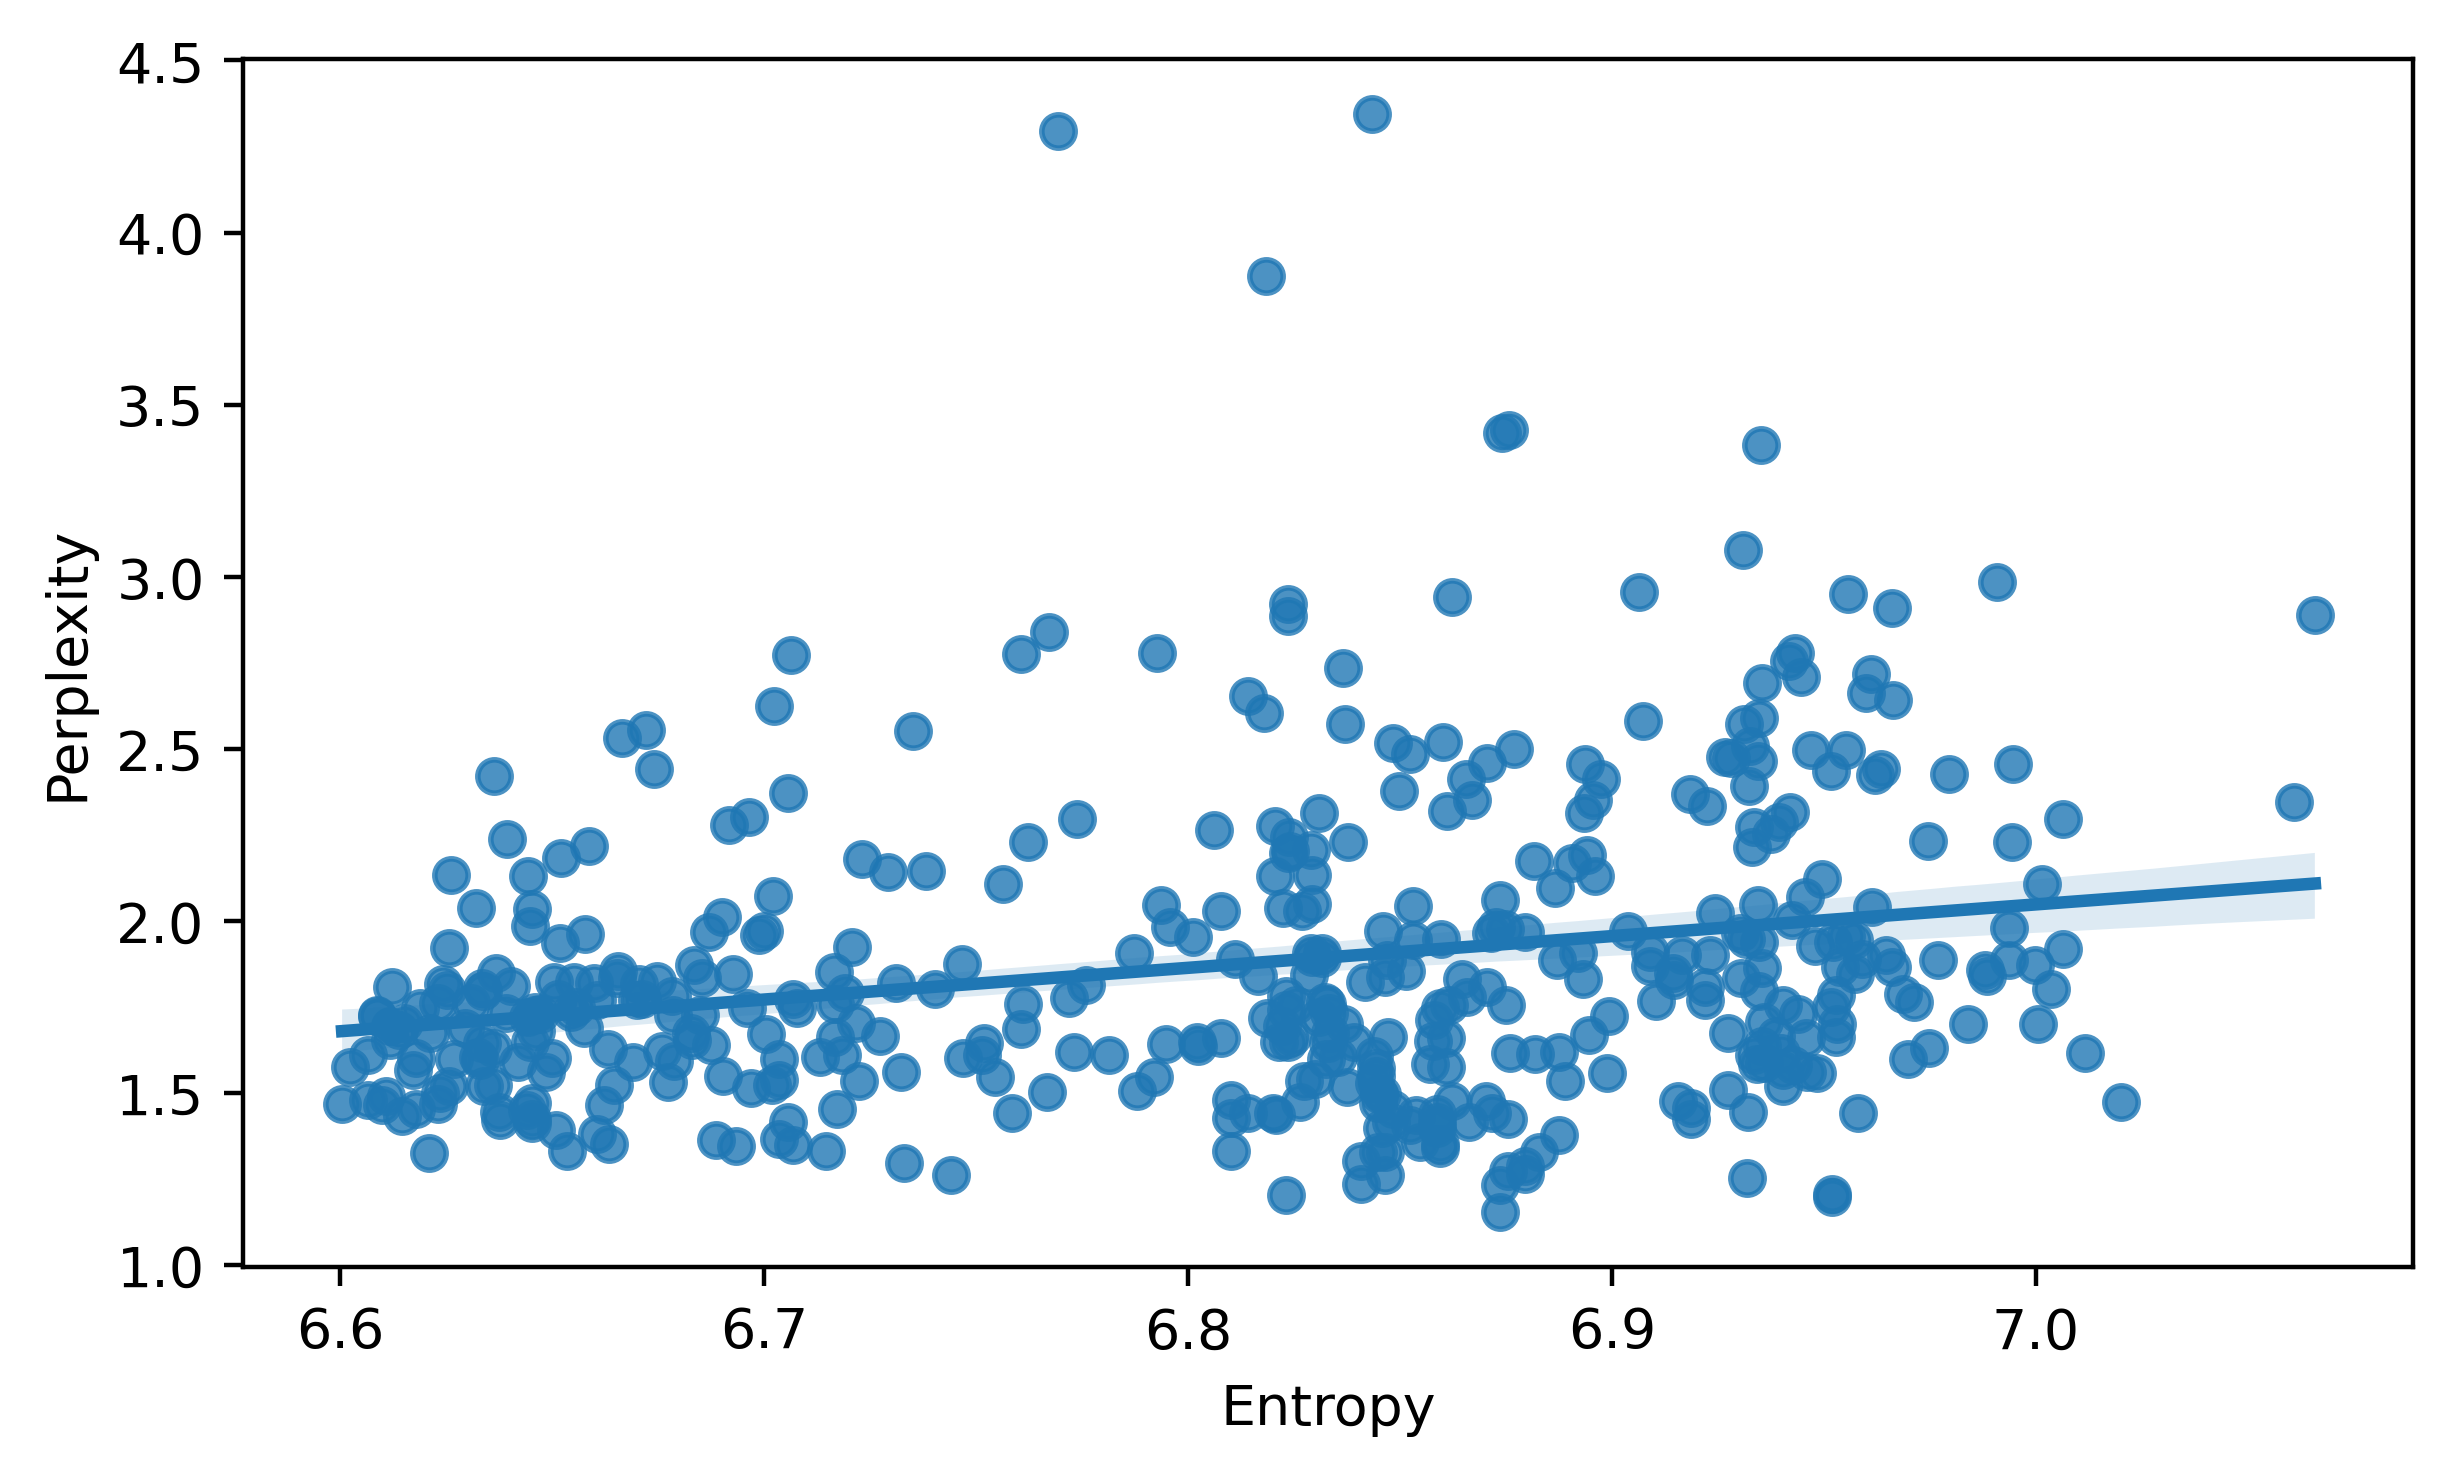

In [5]:
plt.figure(figsize=(x, y), dpi=400) 
sns.regplot(data=df_epoch1, x="Entropy", y="Perplexity")
plt.savefig("cor."+save_format, format=save_format)

## MORPHOLOGY RUN - RESULTS

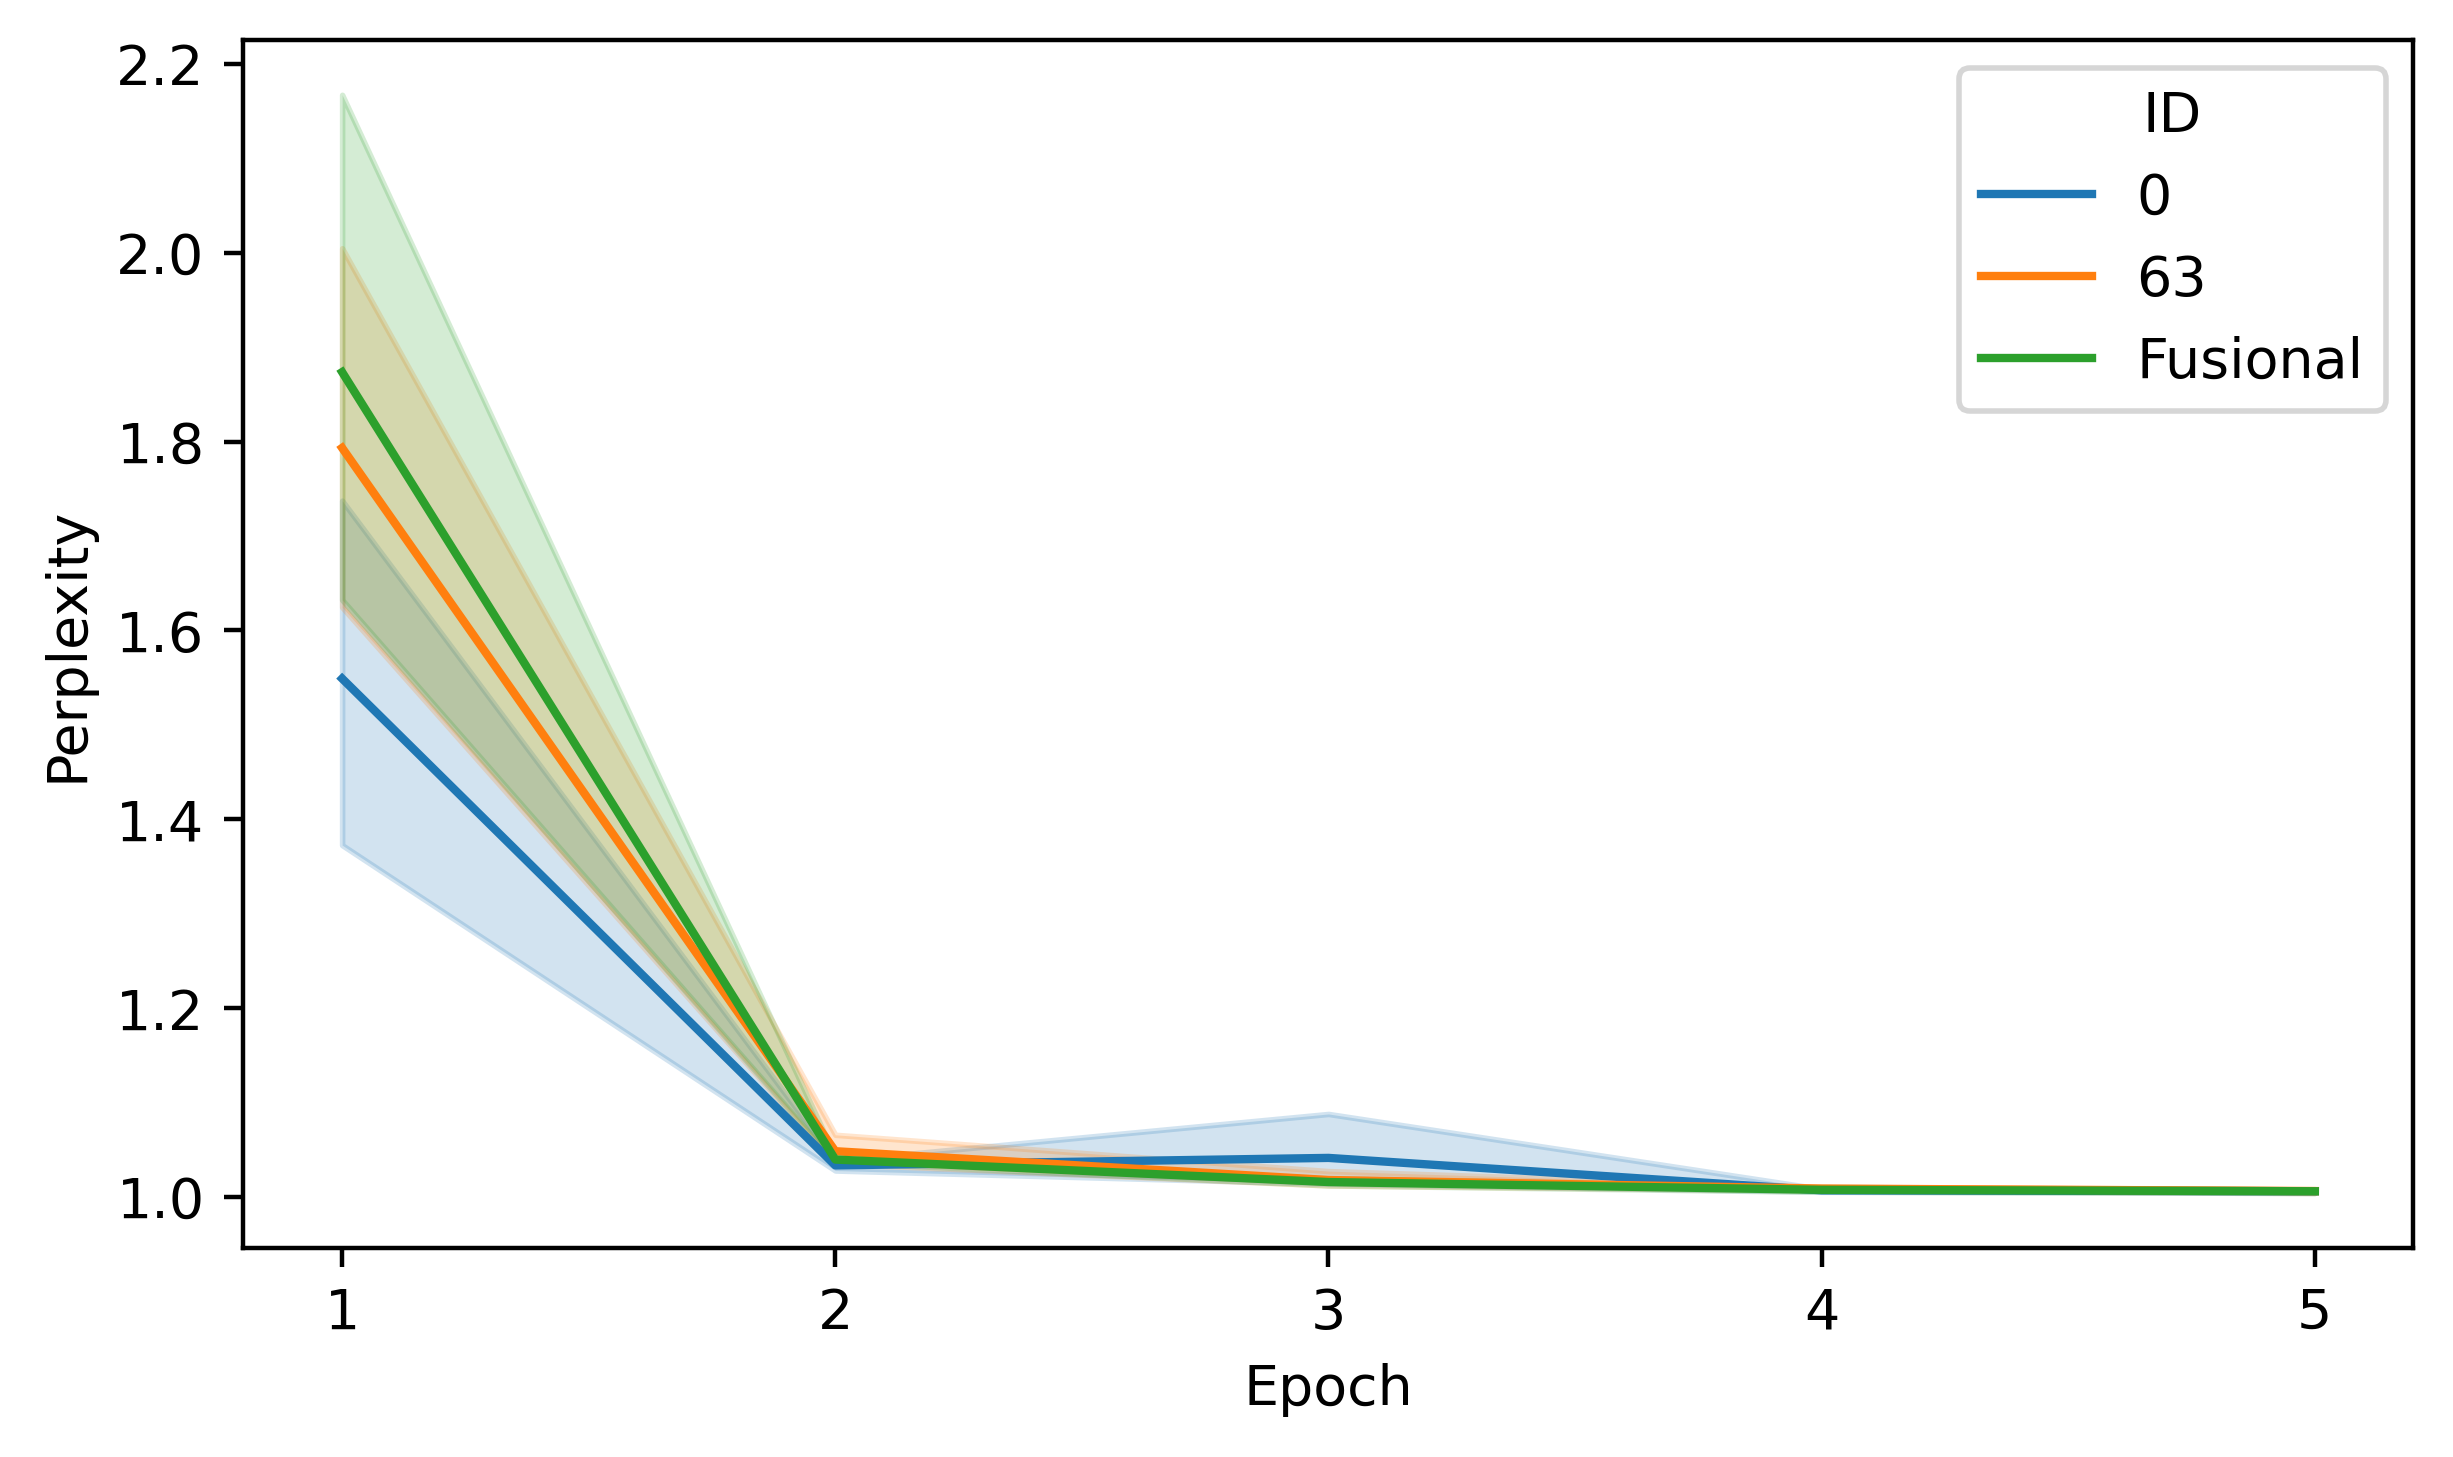

In [6]:
# All three full grammars
df_morph = dfm[(dfm["Run Type"] == "morph") & (dfm["ID"].isin(["0", "63", "Fusional"]))]
plt.figure(figsize=(x, y), dpi=400)
sns.lineplot(data=df_morph, x="Epoch", y="Perplexity", hue="ID")
plt.savefig("morph."+save_format, format=save_format)

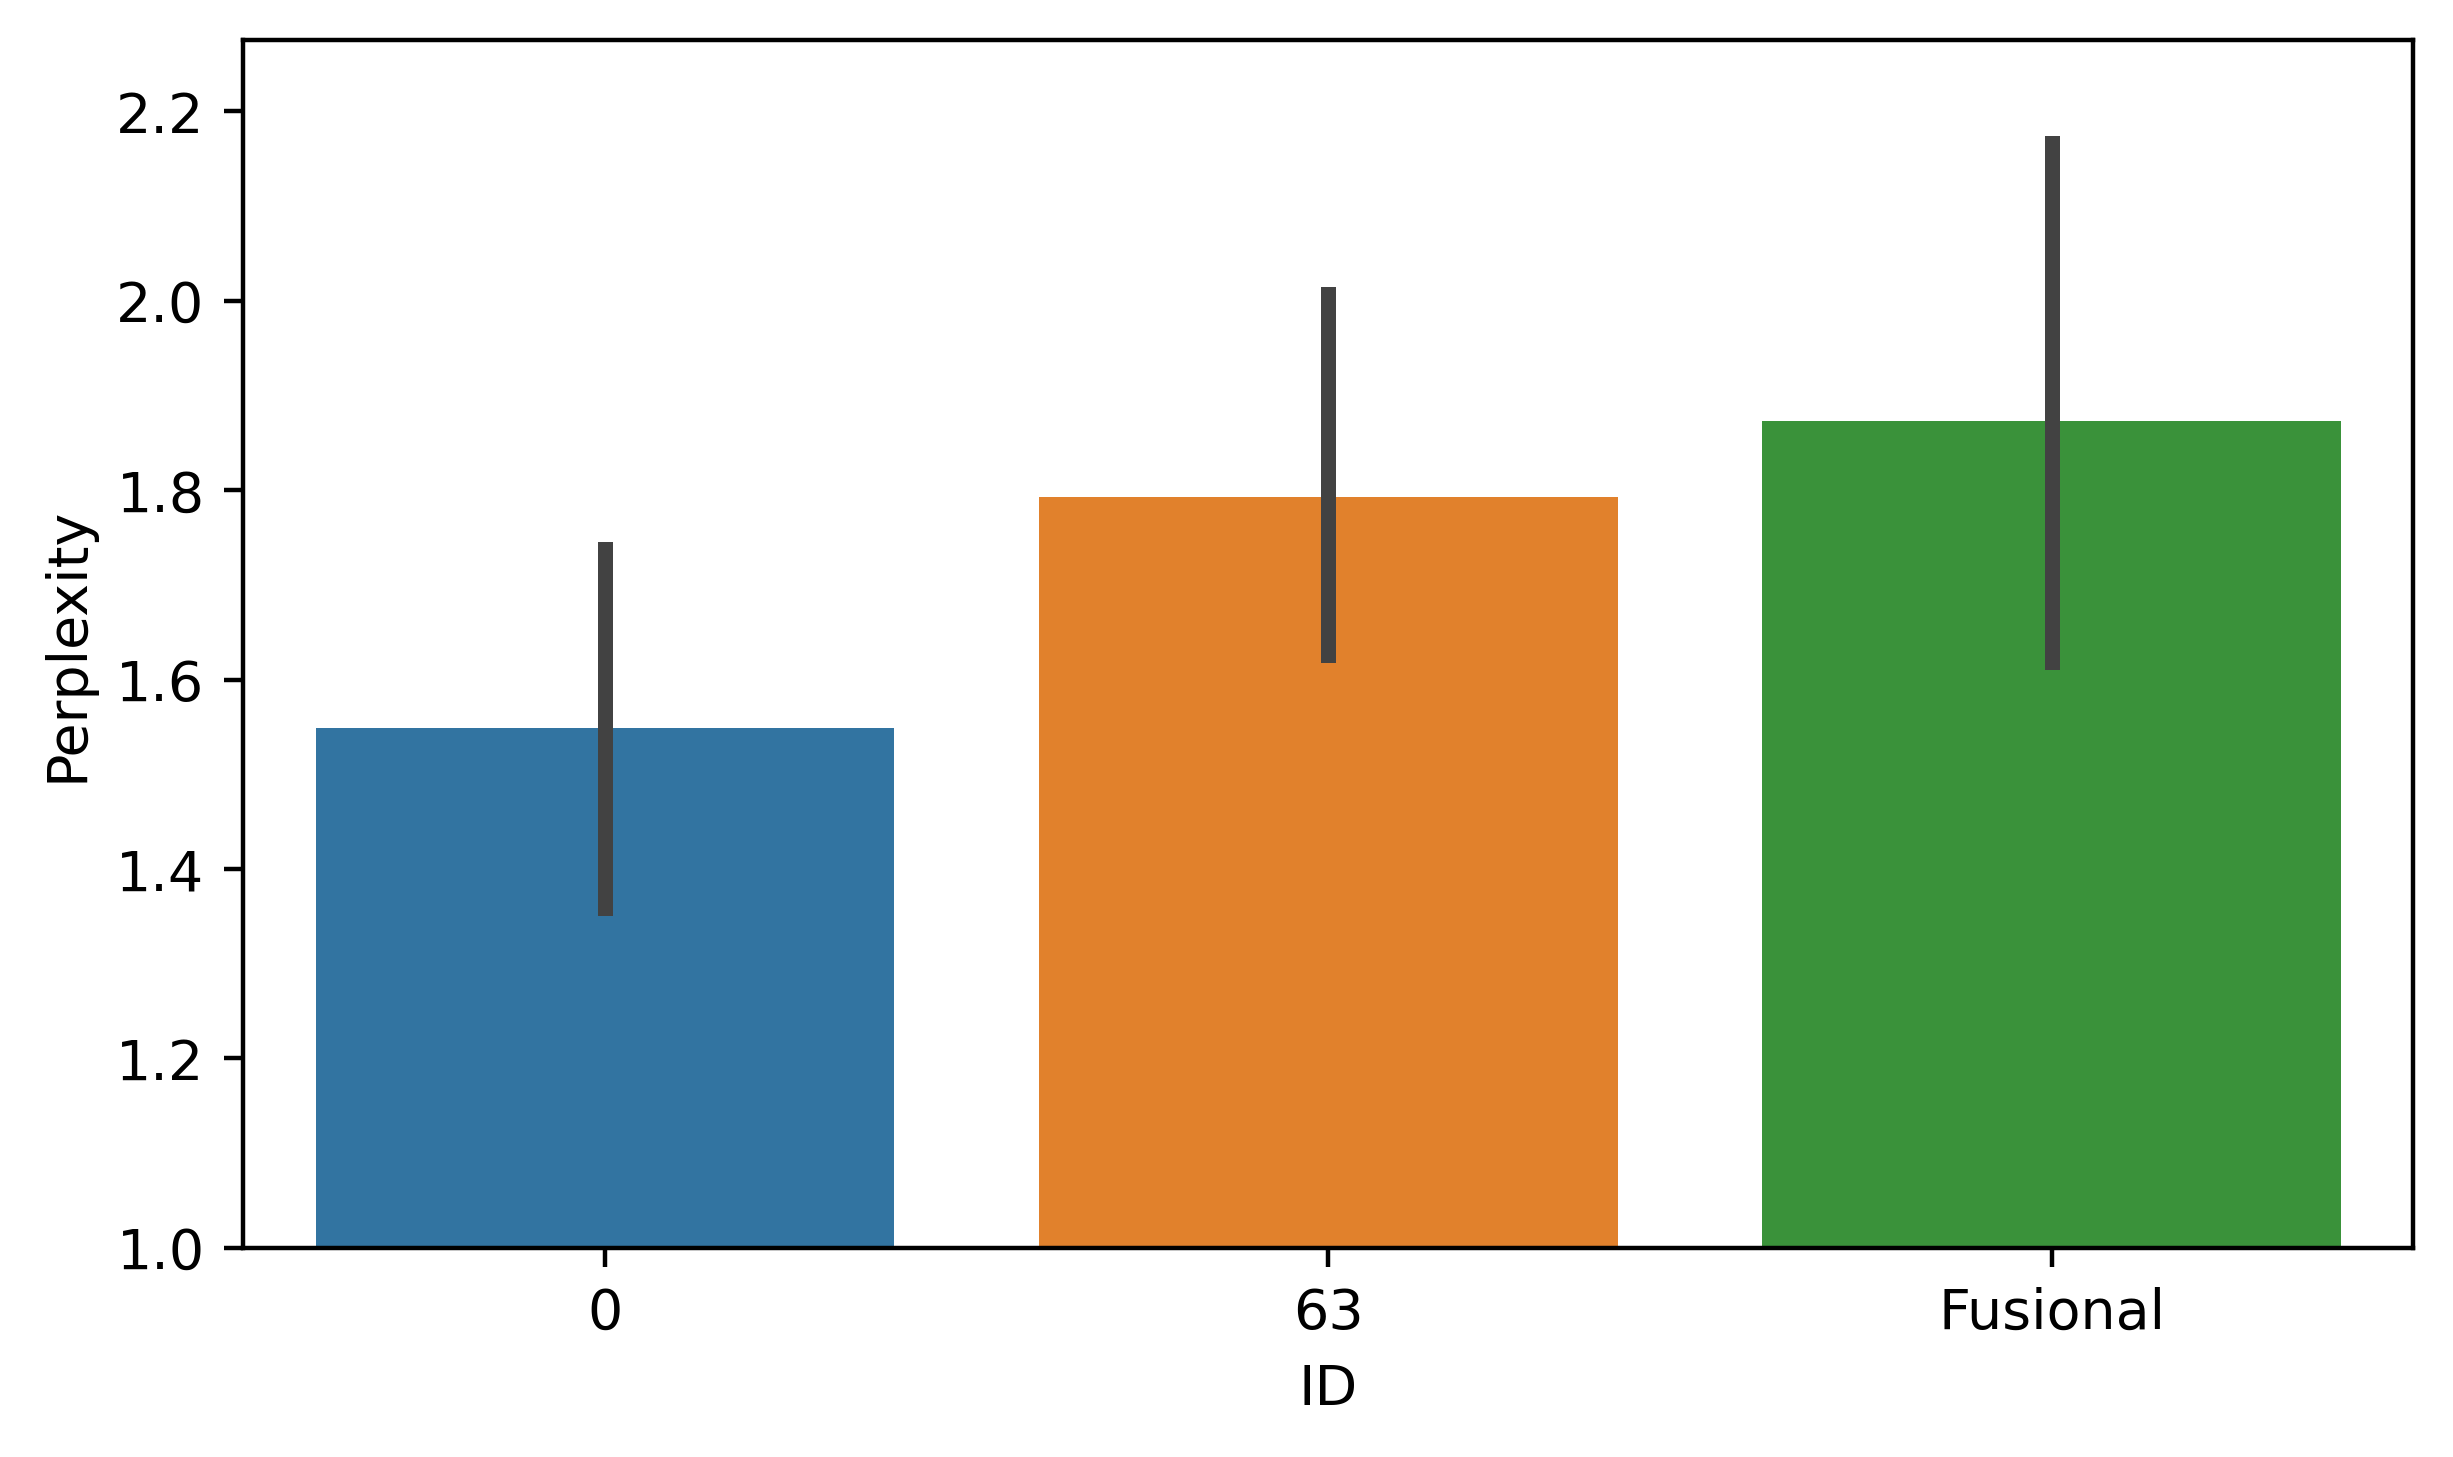

In [7]:
# Epoch 1 bar graph
plt.figure(figsize=(x, y), dpi=400) 
sns.barplot(data=df_morph[df_morph["Epoch"] == "1"], x="ID", y="Perplexity")
plt.ylim(1, None)
plt.savefig("morph-epoch1."+save_format, format=save_format)

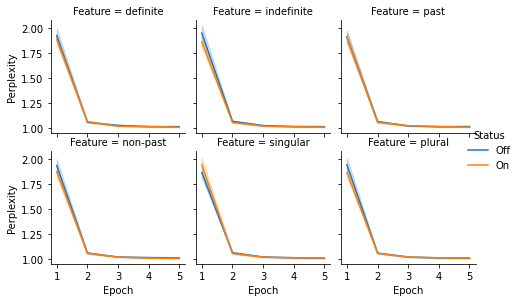

In [8]:
# Series of dropout plots for every switch
df_template = dfm[(dfm["Run Type"] == "morph") & (dfm["ID"] != "Fusional")]
for i, feat in enumerate(["definite", "indefinite", "past", "non-past", "singular", "plural"]):
    # Initialize for appending
    df_appendable = df_template.copy()
    df_appendable["Feature"] = feat
    df_appendable["Status"] = "Off"
    for j in range(64):
        if "{0:06b}".format(j)[i] == "1":
            df_appendable.loc[df_appendable["ID"] == str(j), "Status"] = "On"
    if i == 0:
        df_dropout = df_appendable
    else:
        df_dropout = pd.concat([df_dropout, df_appendable])

# Plot
g = sns.FacetGrid(data=df_dropout, col="Feature", hue="Status", col_wrap=3)
g.map(sns.lineplot, "Epoch", "Perplexity")
g.add_legend()
g.fig.set_size_inches(x, y)
g.savefig("dropout."+save_format, format=save_format, dpi=400)

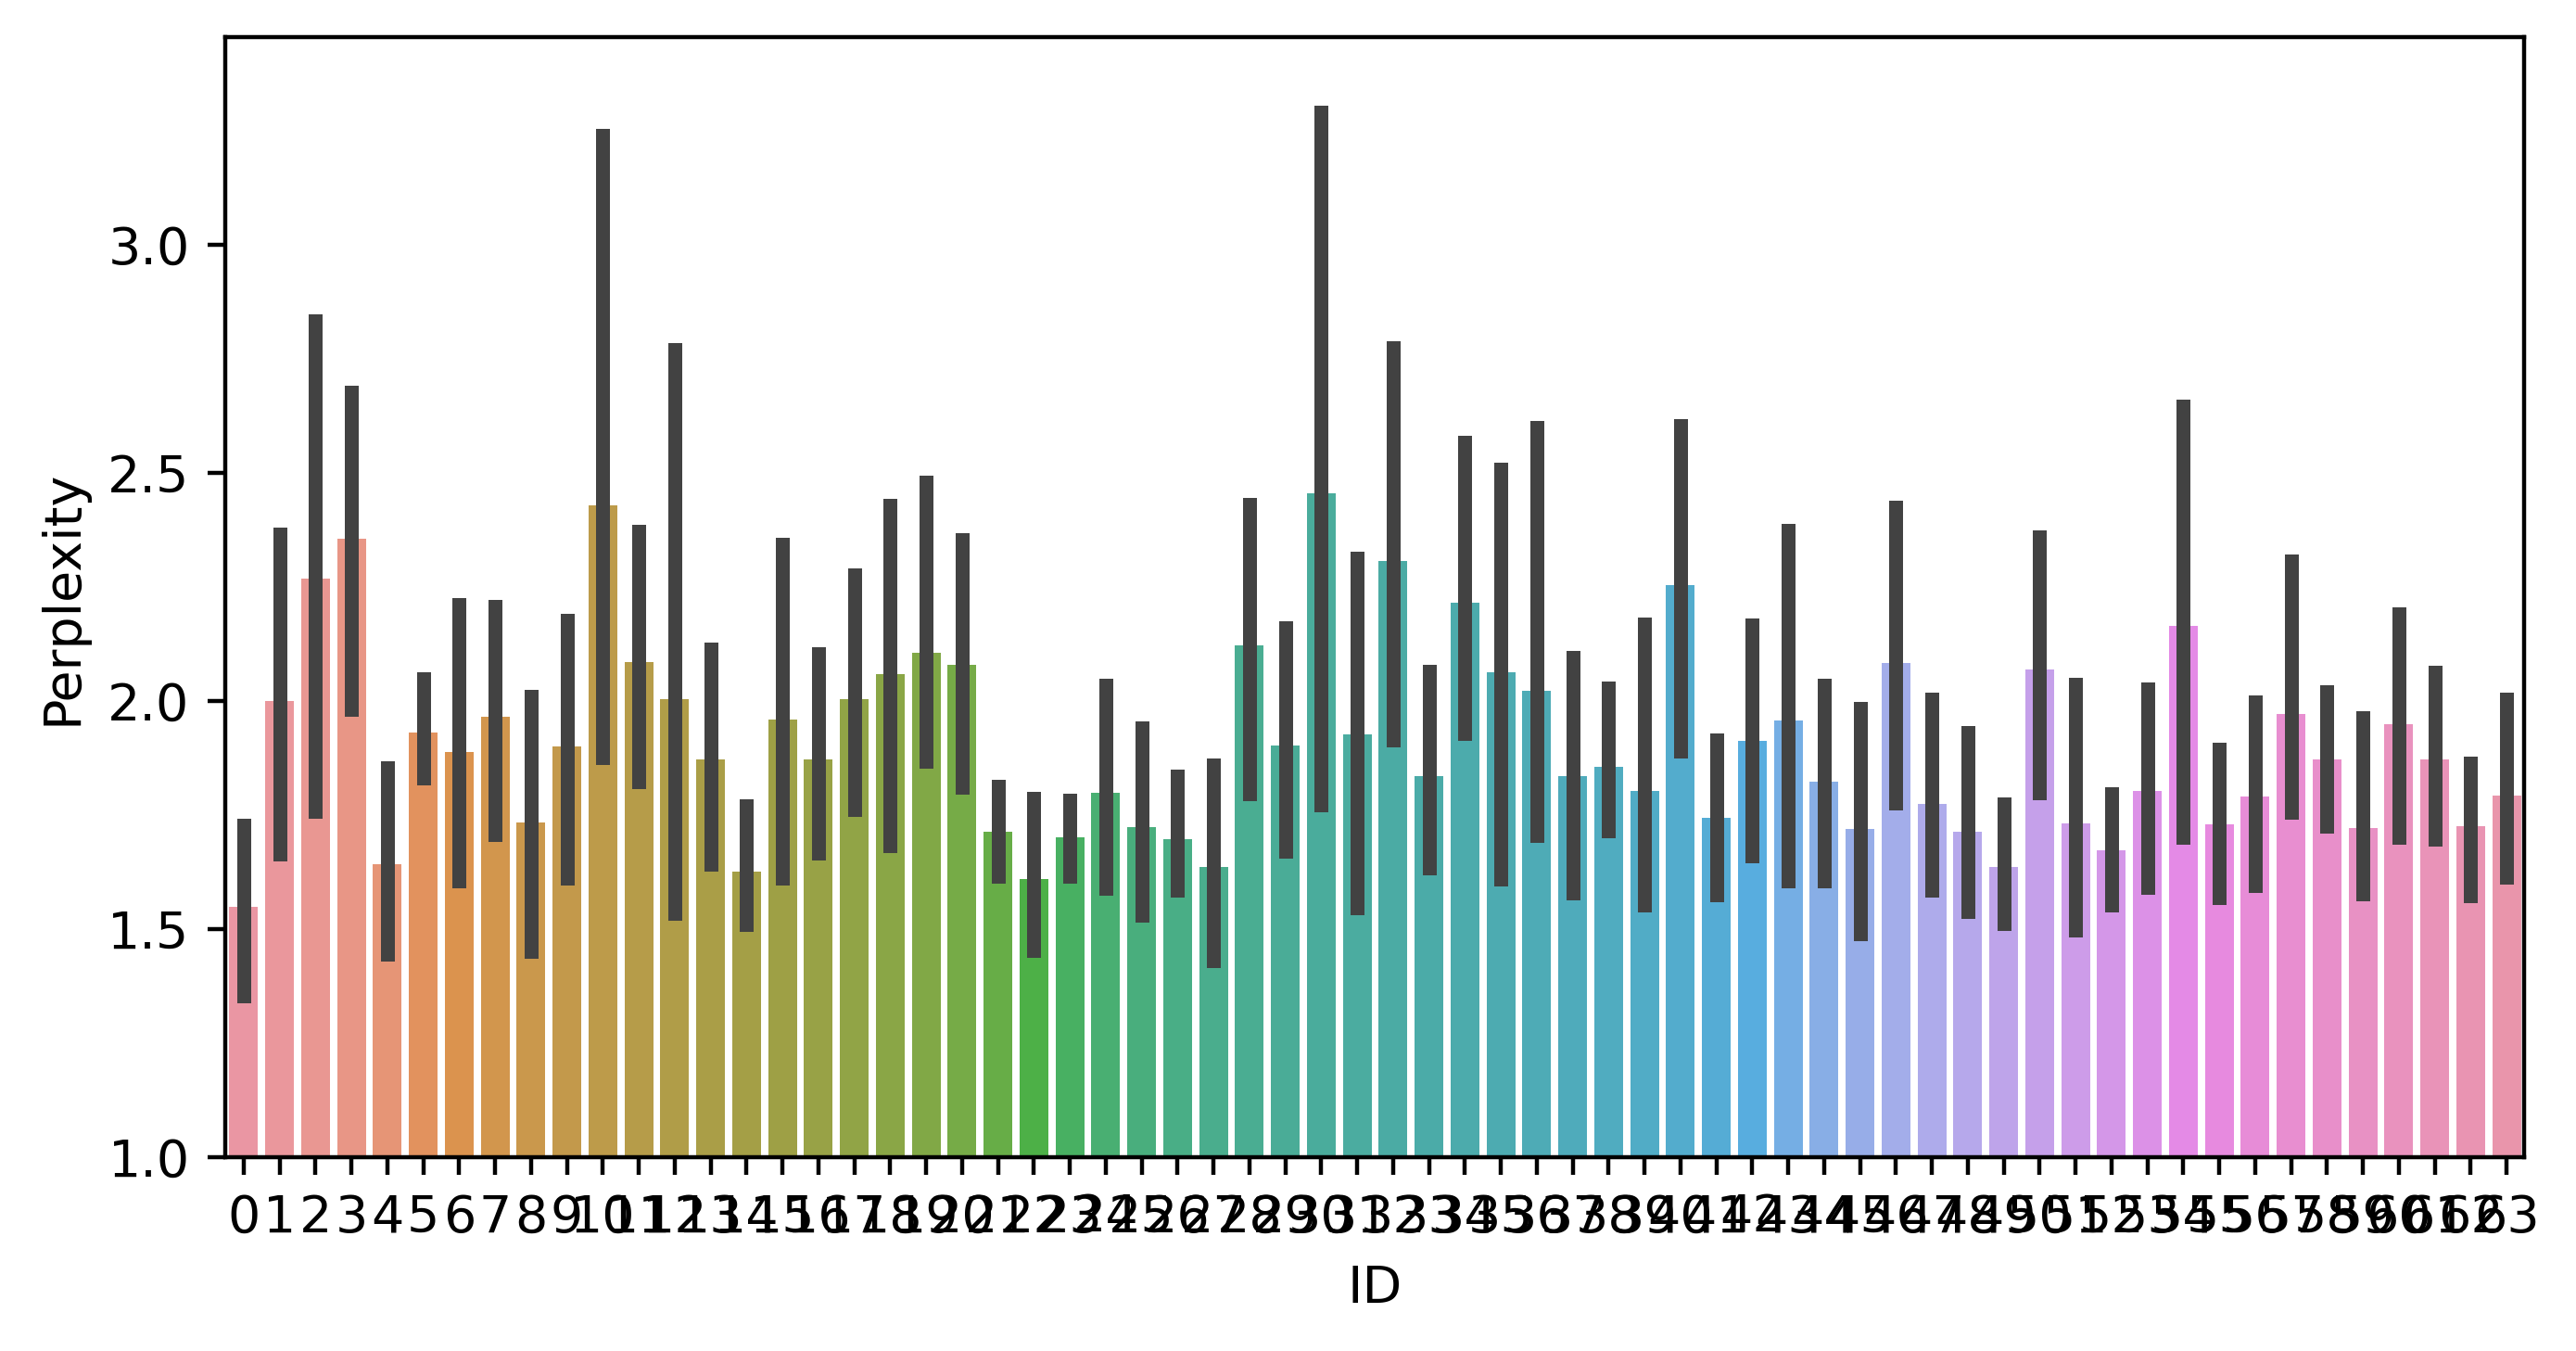

In [9]:
# Epoch 1 bar graph
plt.figure(figsize=(2*y, y), dpi=400)
sns.barplot(data=df_template[df_template["Epoch"] == "1"], x="ID", y="Perplexity")
plt.ylim(1, None)
plt.savefig("morph-epoch1-full."+save_format, format=save_format)

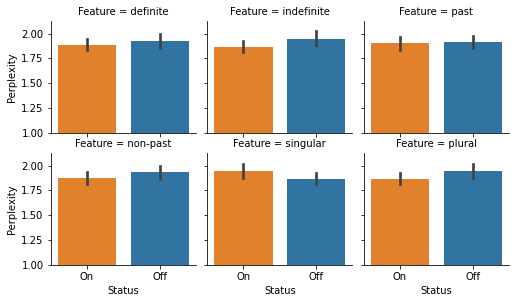

In [19]:
# Epoch 1 bar graph for dropout features
g = sns.FacetGrid(data=df_dropout[df_dropout["Epoch"] == "1"], col="Feature", hue="Status", col_wrap=3)
g.map(sns.barplot, "Status", "Perplexity", order=["On", "Off"])
for ax in g.axes.flat:
    ax.set_ylim(1, None)
#g.add_legend()
g.fig.set_size_inches(x, y)
g.savefig("dropout-epoch1."+save_format, format=save_format, dpi=400)

0.32507739938080493


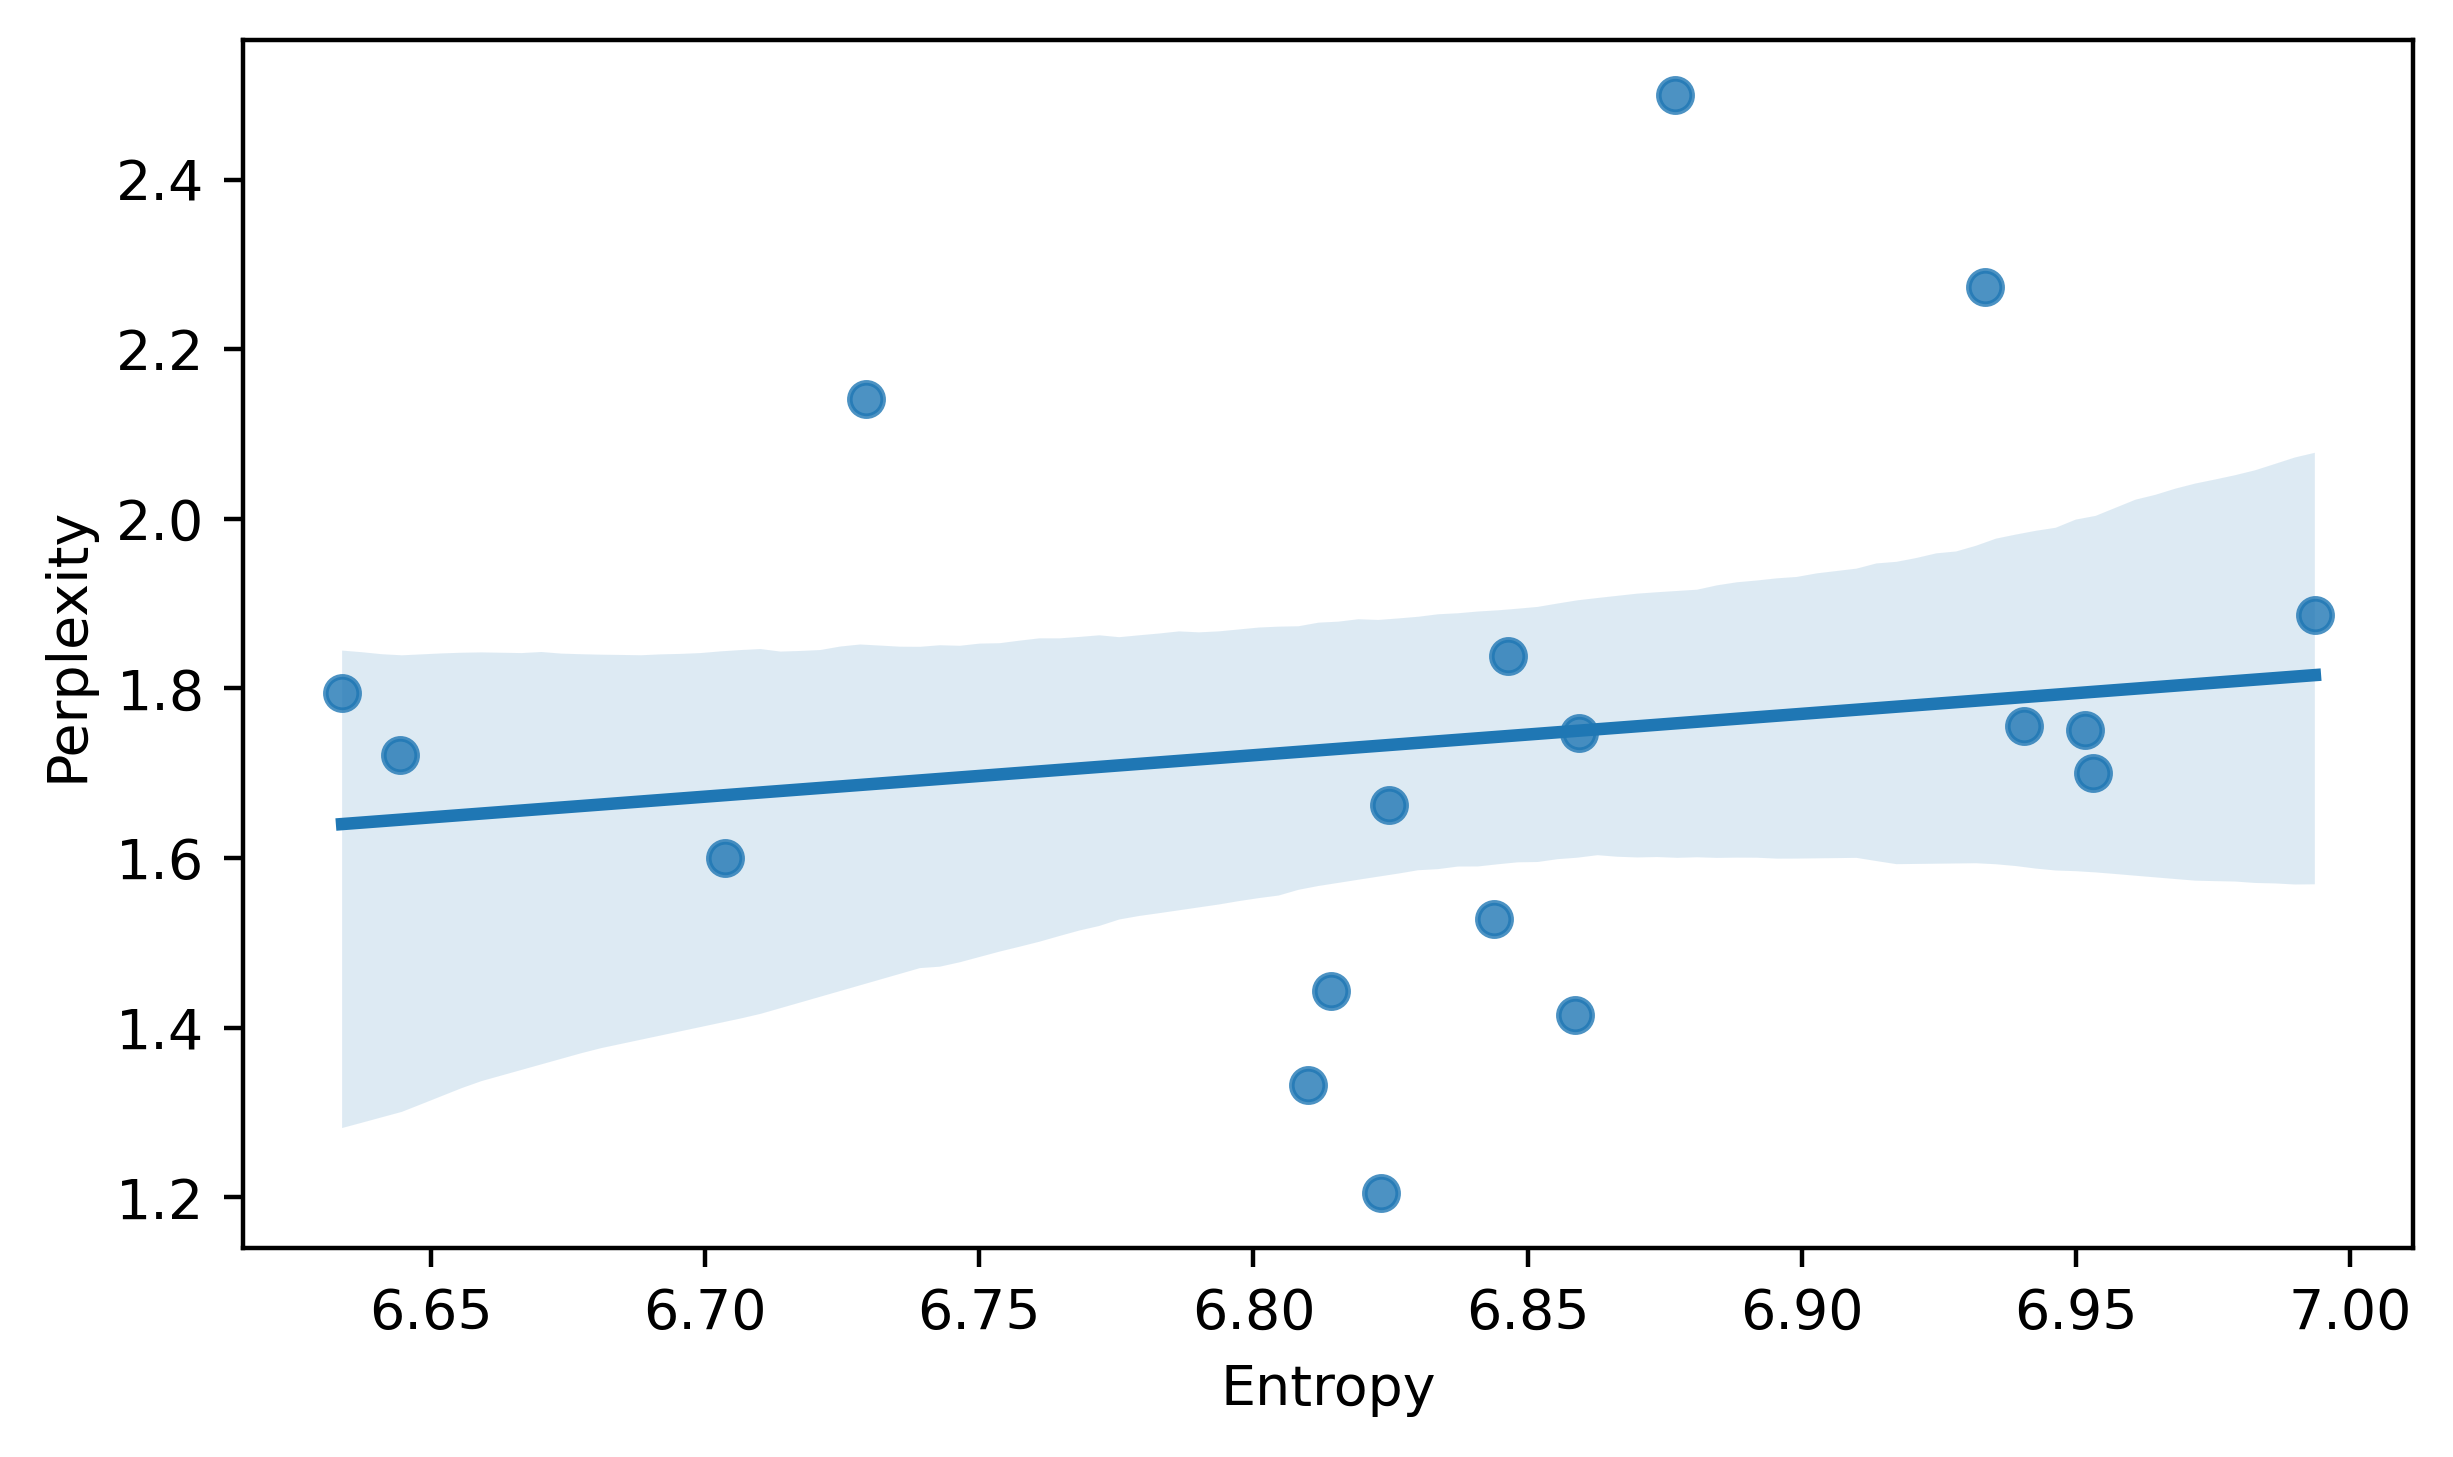

In [11]:
df_morph_cor = df_morph[df_morph["Epoch"] == "1"][["Entropy", "Perplexity"]].corr(method=cor)
print(df_morph_cor.loc["Entropy", "Perplexity"])
plt.figure(figsize=(x, y), dpi=400)
sns.regplot(data=df_morph[df_morph["Epoch"] == "1"], x="Entropy", y="Perplexity")
plt.savefig("cor-morph."+save_format, format=save_format)

0.3556282001288529


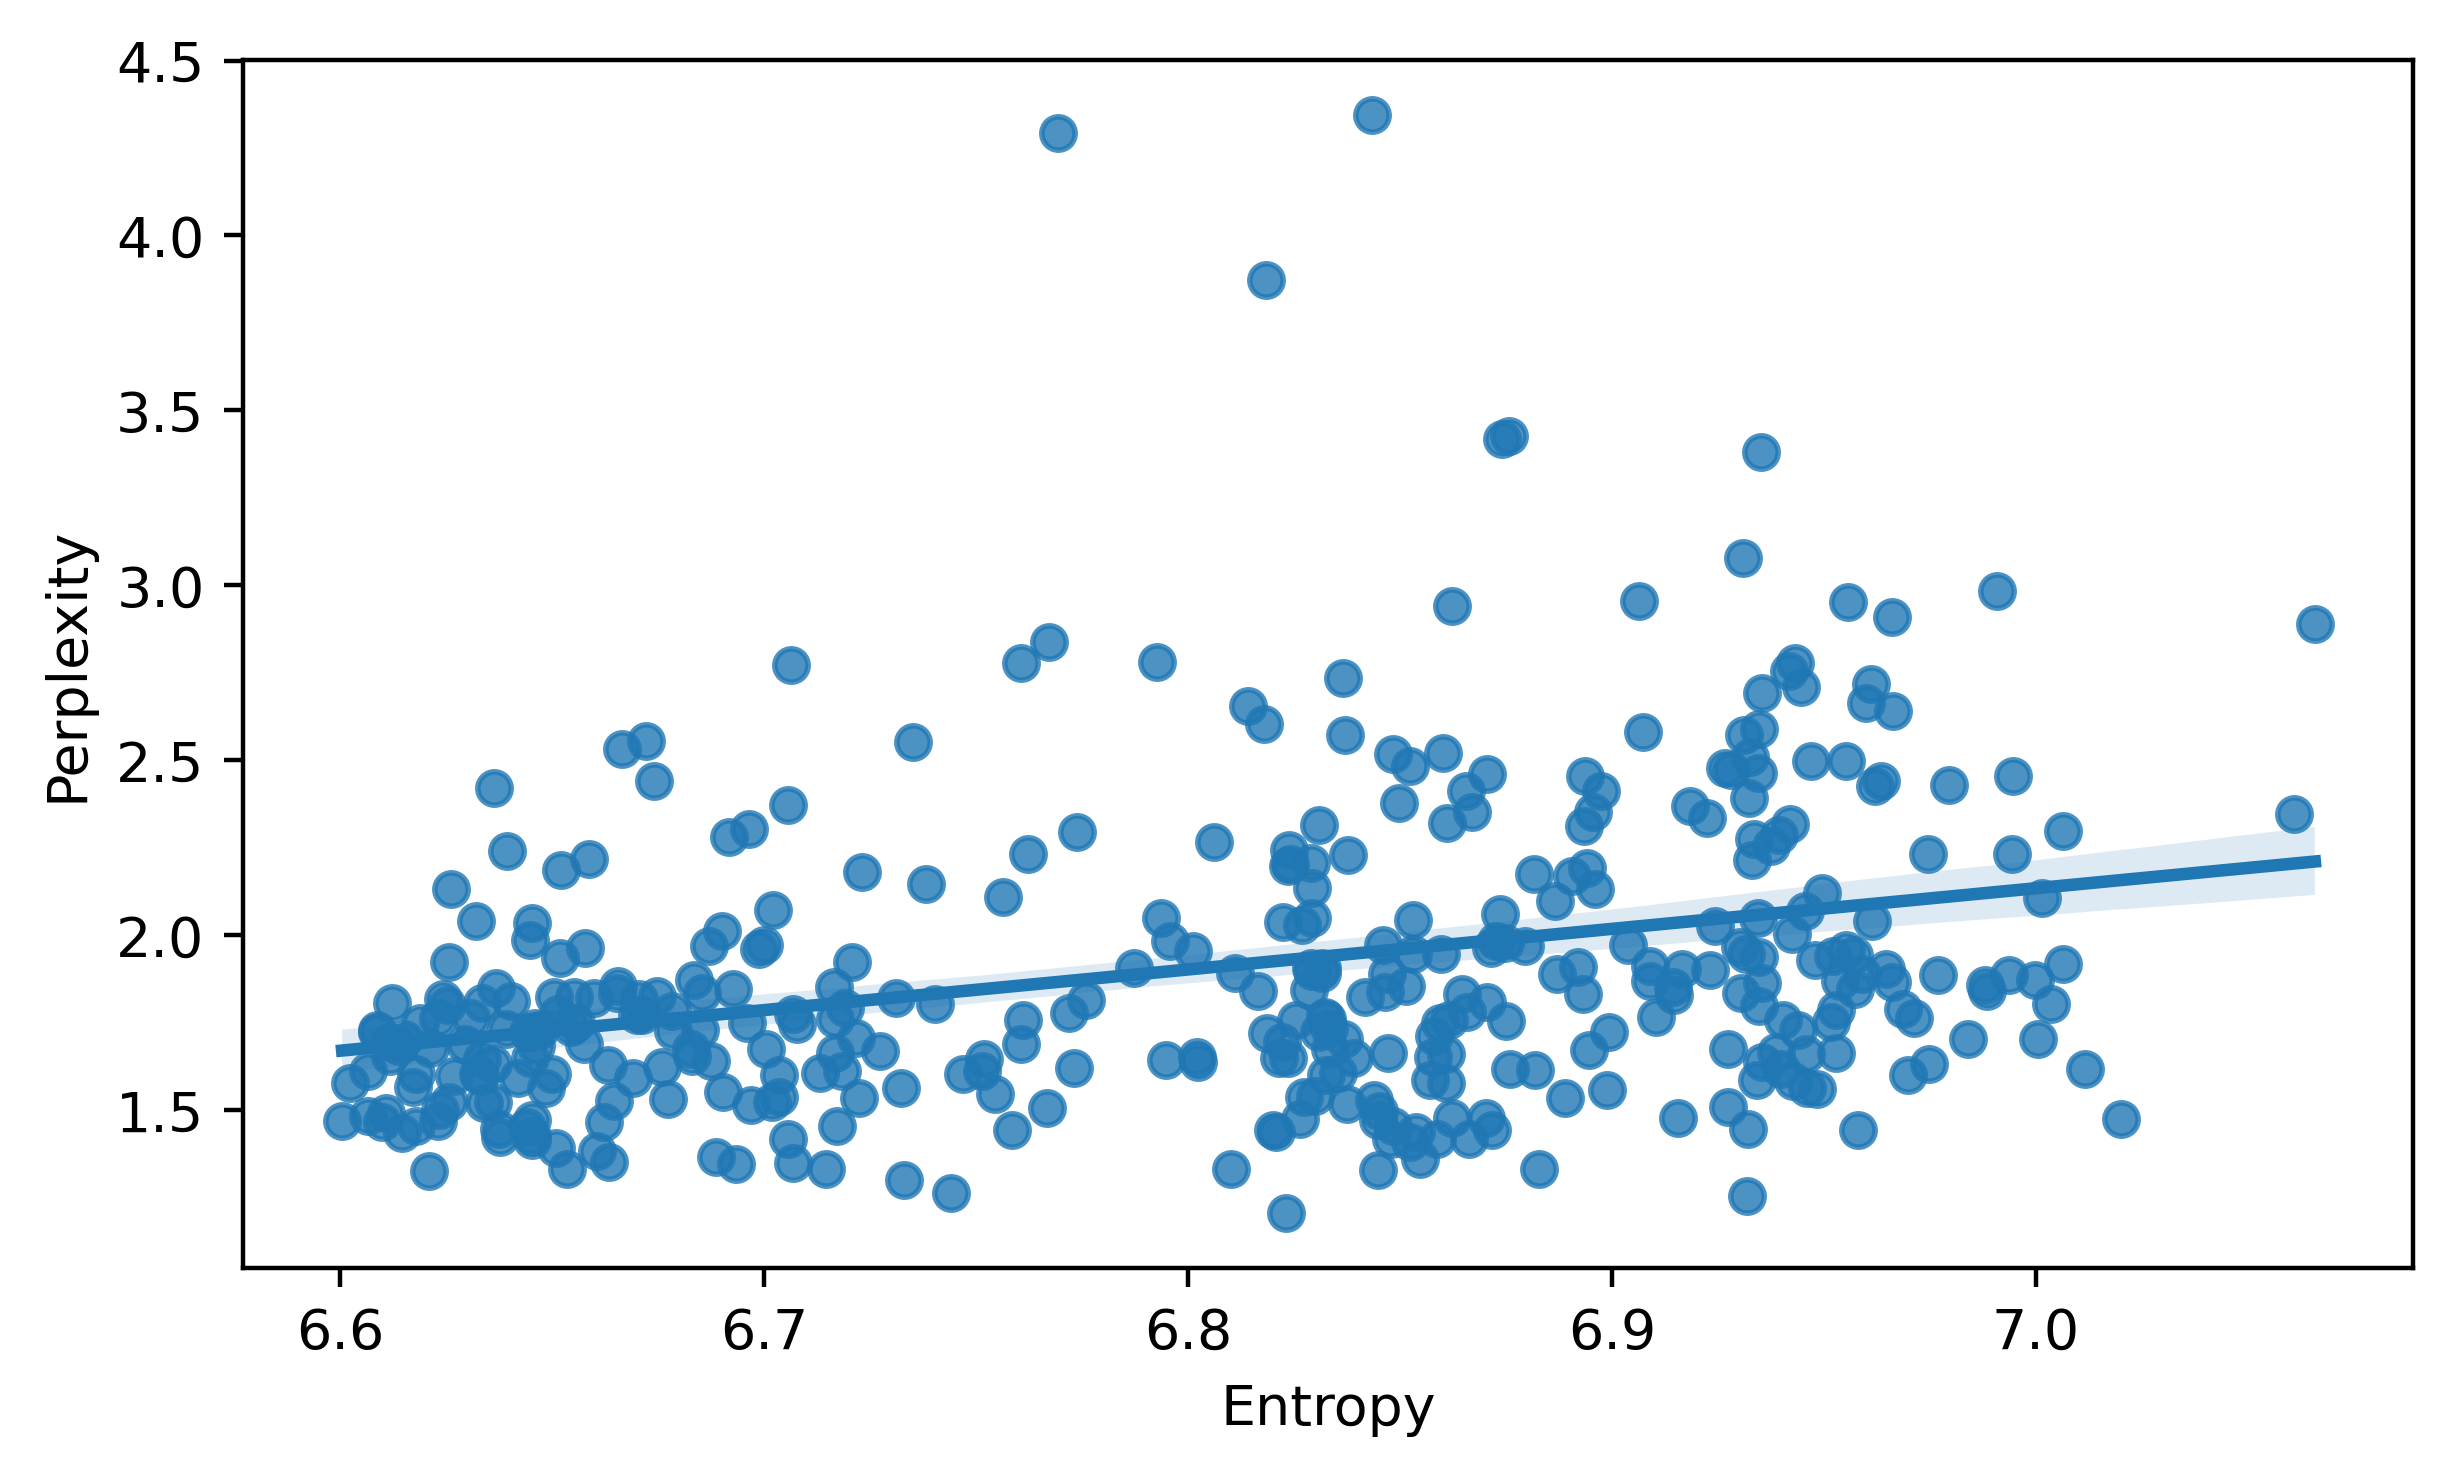

In [12]:
df_dropout_cor = df_template[df_template["Epoch"] == "1"][["Entropy", "Perplexity"]].corr(method=cor)
print(df_dropout_cor.loc["Entropy", "Perplexity"])
plt.figure(figsize=(x, y), dpi=400)
sns.regplot(data=df_template[df_template["Epoch"] == "1"], x="Entropy", y="Perplexity")
plt.savefig("cor-morph-dropout."+save_format, format=save_format)

In [13]:
dfm_epoch1 = df_morph[df_morph["Epoch"] == "1"]
predf_morph = {"Entropy Mean": {}, "Entropy SE": {}, "Perplexity Mean": {}, "Perplexity SE": {}}
for id_type in ["0", "63", "Fusional"]:
    predf_morph["Entropy Mean"][id_type] = dfm_epoch1[dfm_epoch1["ID"] == id_type]["Entropy"].mean()
    predf_morph["Entropy SE"][id_type] = dfm_epoch1[dfm_epoch1["ID"] == id_type]["Entropy"].sem()
    predf_morph["Perplexity Mean"][id_type] = dfm_epoch1[dfm_epoch1["ID"] == id_type]["Perplexity"].mean()
    predf_morph["Perplexity SE"][id_type] = dfm_epoch1[dfm_epoch1["ID"] == id_type]["Perplexity"].sem()
dfm_mse = pd.DataFrame(predf_morph)
dfm_mse

,Entropy Mean,Entropy SE,Perplexity Mean,Perplexity SE
0,6.856375,0.018644,1.549054,0.107865
63,6.845070,0.058180,1.793319,0.108613
Fusional,6.805301,0.045682,1.873589,0.155991


In [14]:
dfd_epoch1 = df_dropout[df_dropout["Epoch"] == "1"]
predf_dropout = {"Entropy Mean": {}, "Entropy SE": {}, "Perplexity Mean": {}, "Perplexity SE": {}}
for id_type in dfd_epoch1["Feature"].unique():
    # Flip flop on and off
    predf_dropout["Entropy Mean"][id_type+"-Off"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                               (dfd_epoch1["Status"] == "Off")]["Entropy"].mean()
    predf_dropout["Entropy Mean"][id_type+"-On"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                              (dfd_epoch1["Status"] == "On")]["Entropy"].mean()
    predf_dropout["Entropy SE"][id_type+"-Off"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                             (dfd_epoch1["Status"] == "Off")]["Entropy"].sem()
    predf_dropout["Entropy SE"][id_type+"-On"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                             (dfd_epoch1["Status"] == "On")]["Entropy"].sem()
    predf_dropout["Perplexity Mean"][id_type+"-Off"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                                  (dfd_epoch1["Status"] == "Off")]["Perplexity"].mean()
    predf_dropout["Perplexity Mean"][id_type+"-On"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                                 (dfd_epoch1["Status"] == "On")]["Perplexity"].mean()
    predf_dropout["Perplexity SE"][id_type+"-Off"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                                (dfd_epoch1["Status"] == "Off")]["Perplexity"].sem()
    predf_dropout["Perplexity SE"][id_type+"-On"] = dfd_epoch1[(dfd_epoch1["Feature"] == id_type) &
                                                               (dfd_epoch1["Status"] == "On")]["Perplexity"].sem()
dfd_mse = pd.DataFrame(predf_dropout)
dfd_mse

,Entropy Mean,Entropy SE,Perplexity Mean,Perplexity SE
definite-Off,6.807415,0.007969,1.925265,0.035658
definite-On,6.801782,0.009558,1.887978,0.028621
indefinite-Off,6.797746,0.008679,1.950269,0.035375
indefinite-On,6.811451,0.008895,1.862974,0.028688
past-Off,6.812087,0.008512,1.912385,0.031235
past-On,6.797109,0.009050,1.900859,0.033441
non-past-Off,6.807200,0.008369,1.937764,0.033273
non-past-On,6.801997,0.009210,1.875480,0.031258
singular-Off,6.795781,0.007917,1.868408,0.028596
singular-On,6.813415,0.009563,1.944836,0.035514


## ORTHOGRAPHY RUN - RESULTS

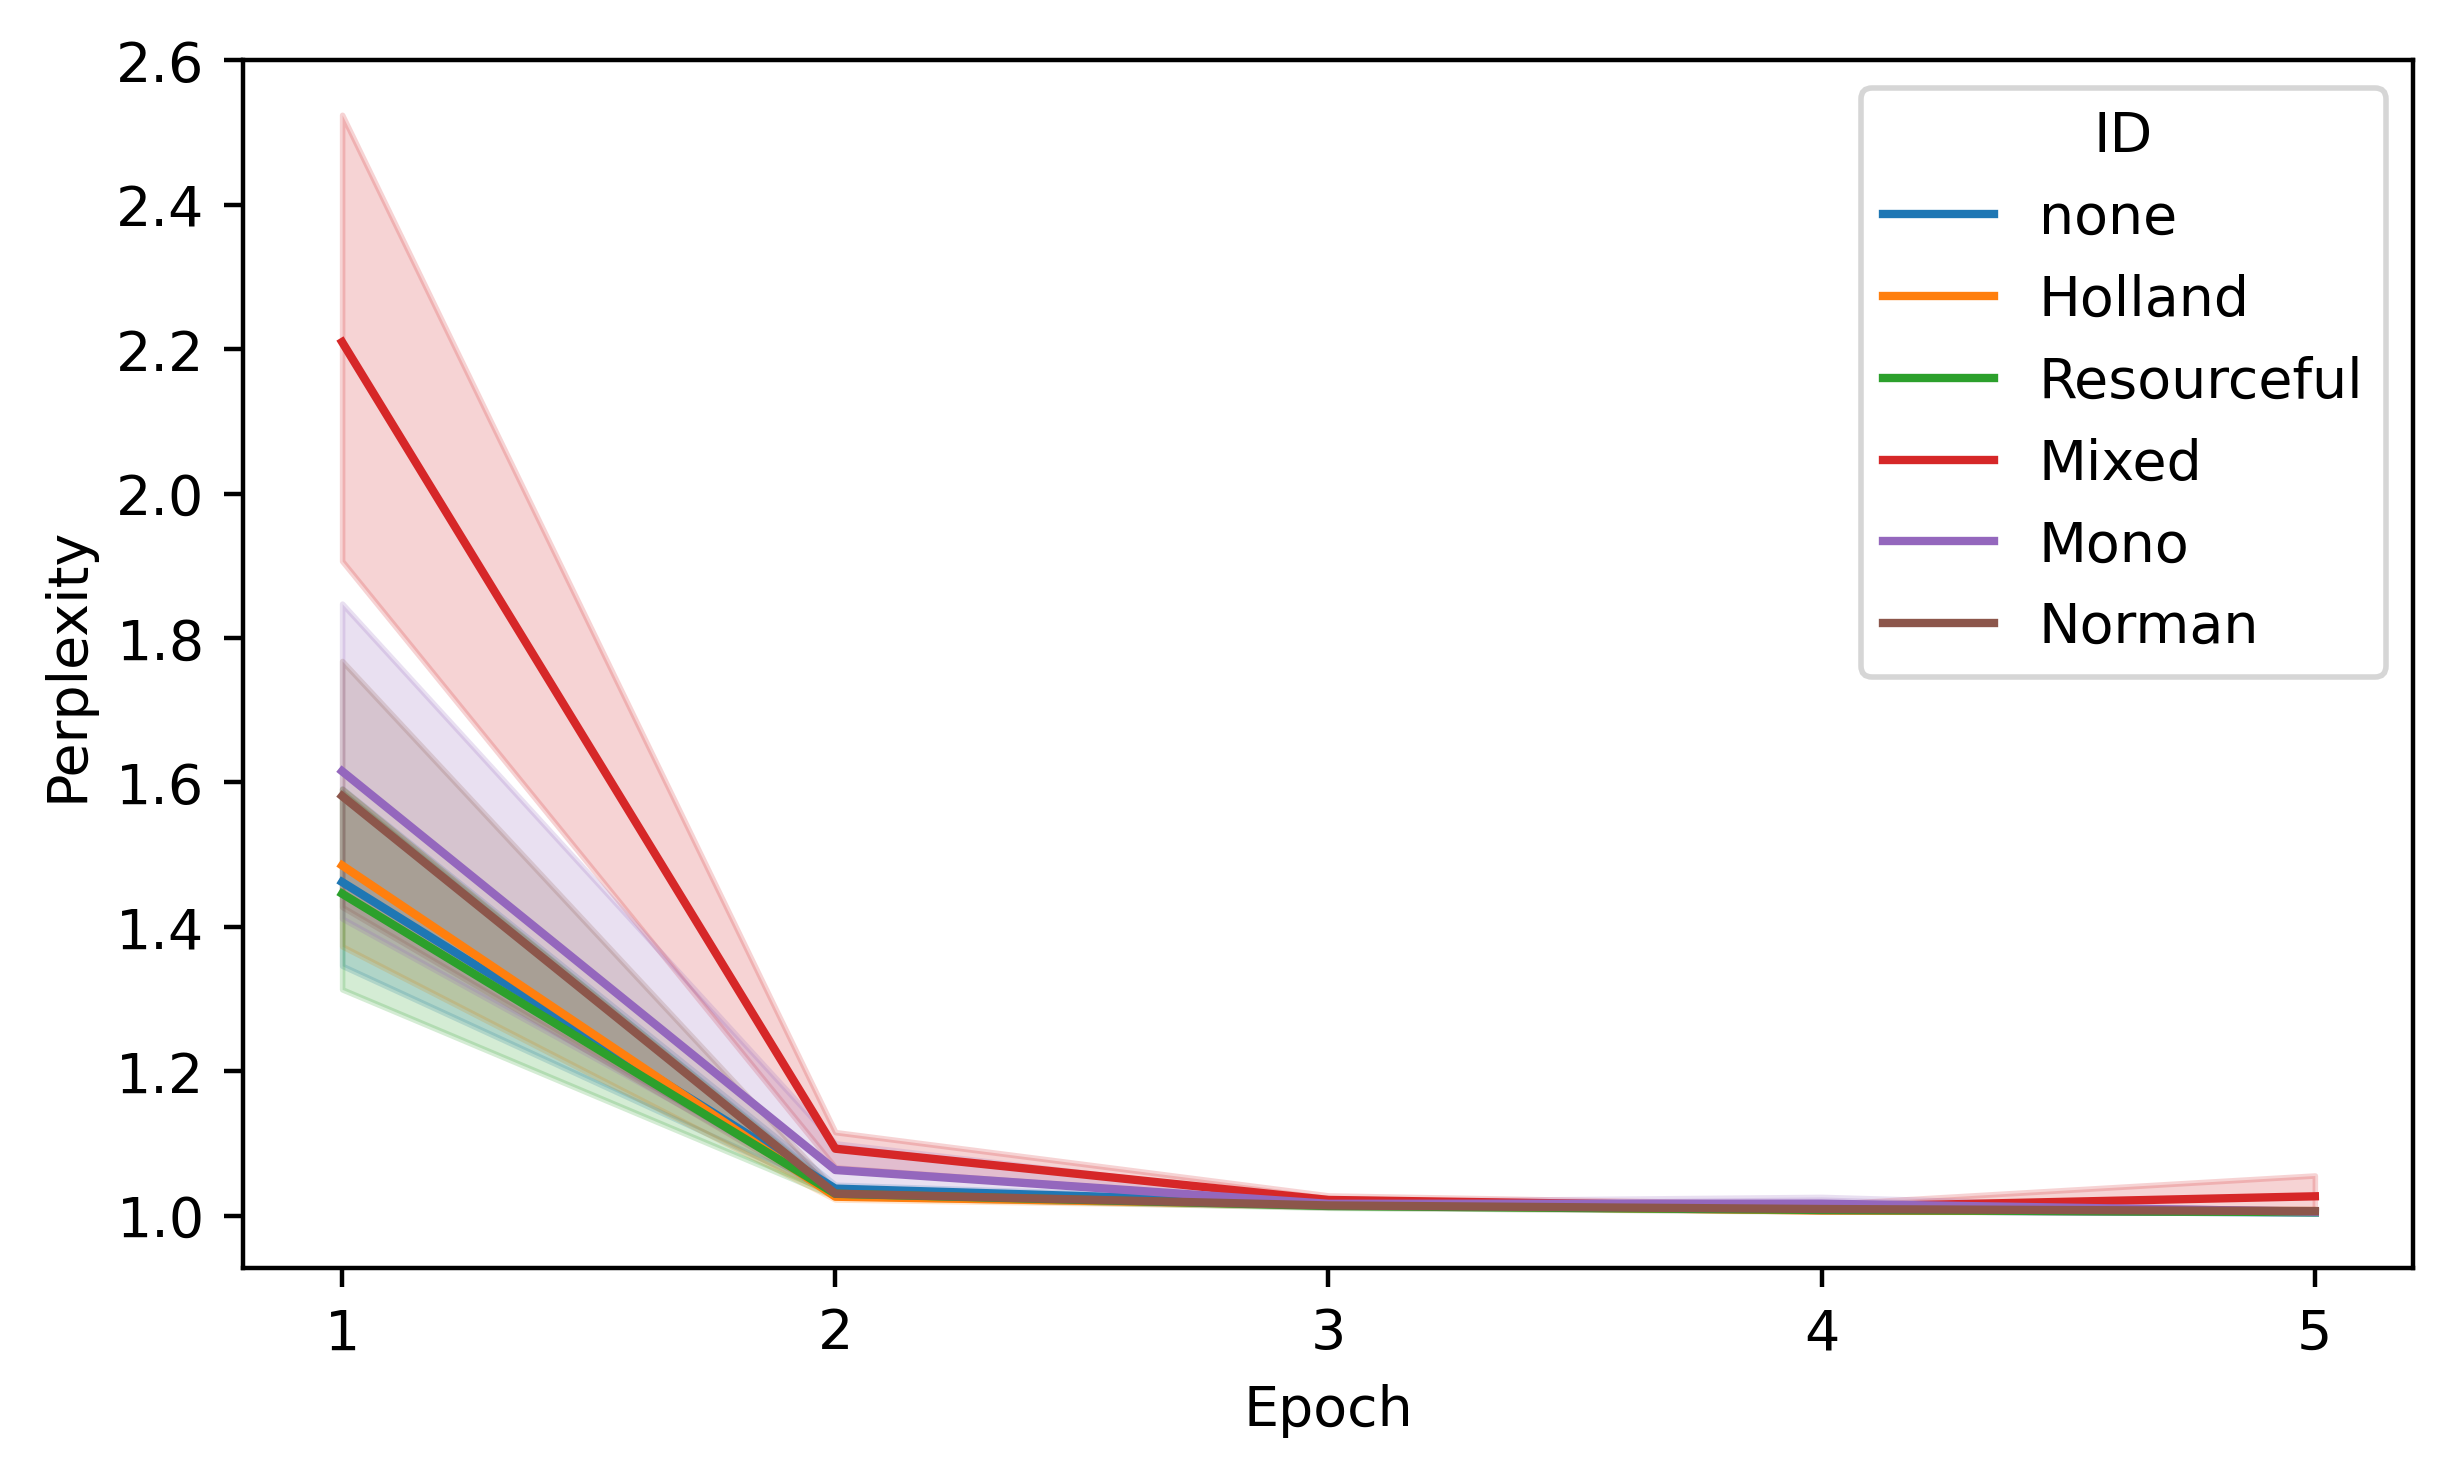

In [15]:
df_ortho = dfm[dfm["Run Type"] == "ortho"]
plt.figure(figsize=(x, y), dpi=400) 
sns.lineplot(data=df_ortho, x="Epoch", y="Perplexity", hue="ID")
plt.savefig("ortho."+save_format, format=save_format)

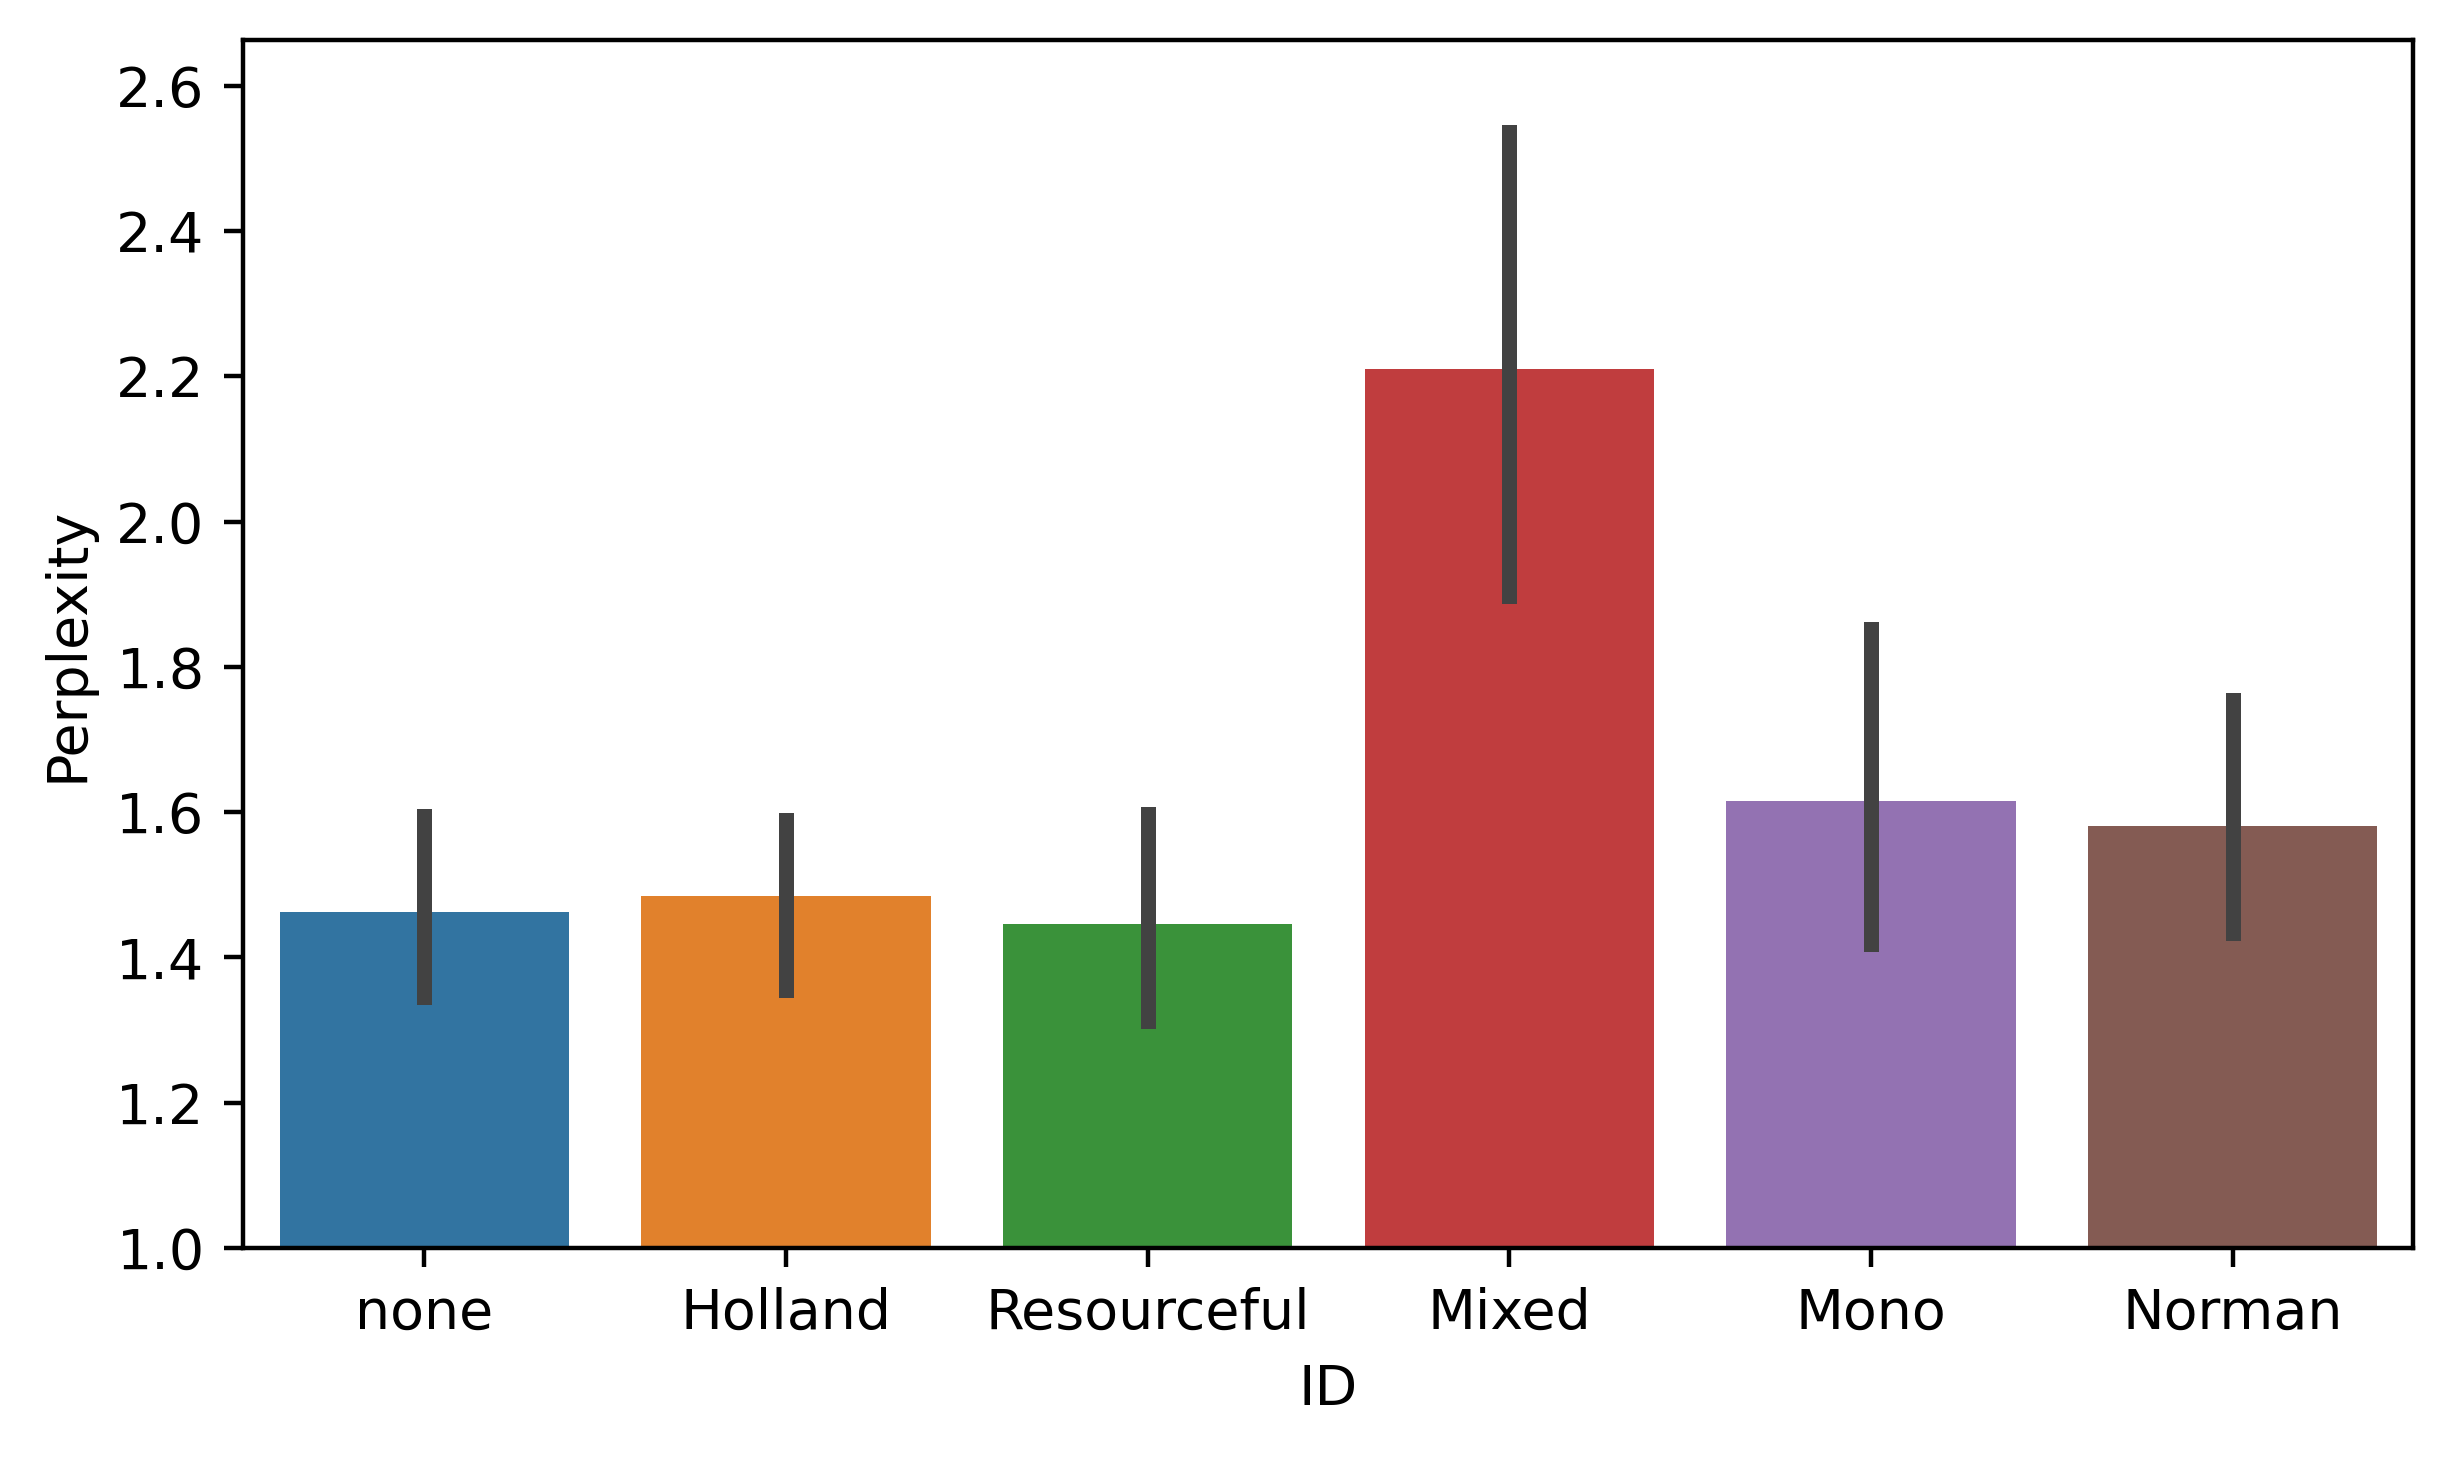

In [16]:
# Epoch 1 bar graph
plt.figure(figsize=(x, y), dpi=400) 
sns.barplot(data=df_ortho[df_ortho["Epoch"] == "1"], x="ID", y="Perplexity")
plt.ylim(1, None)
plt.savefig("ortho-epoch1."+save_format, format=save_format)

-0.31159919473777953


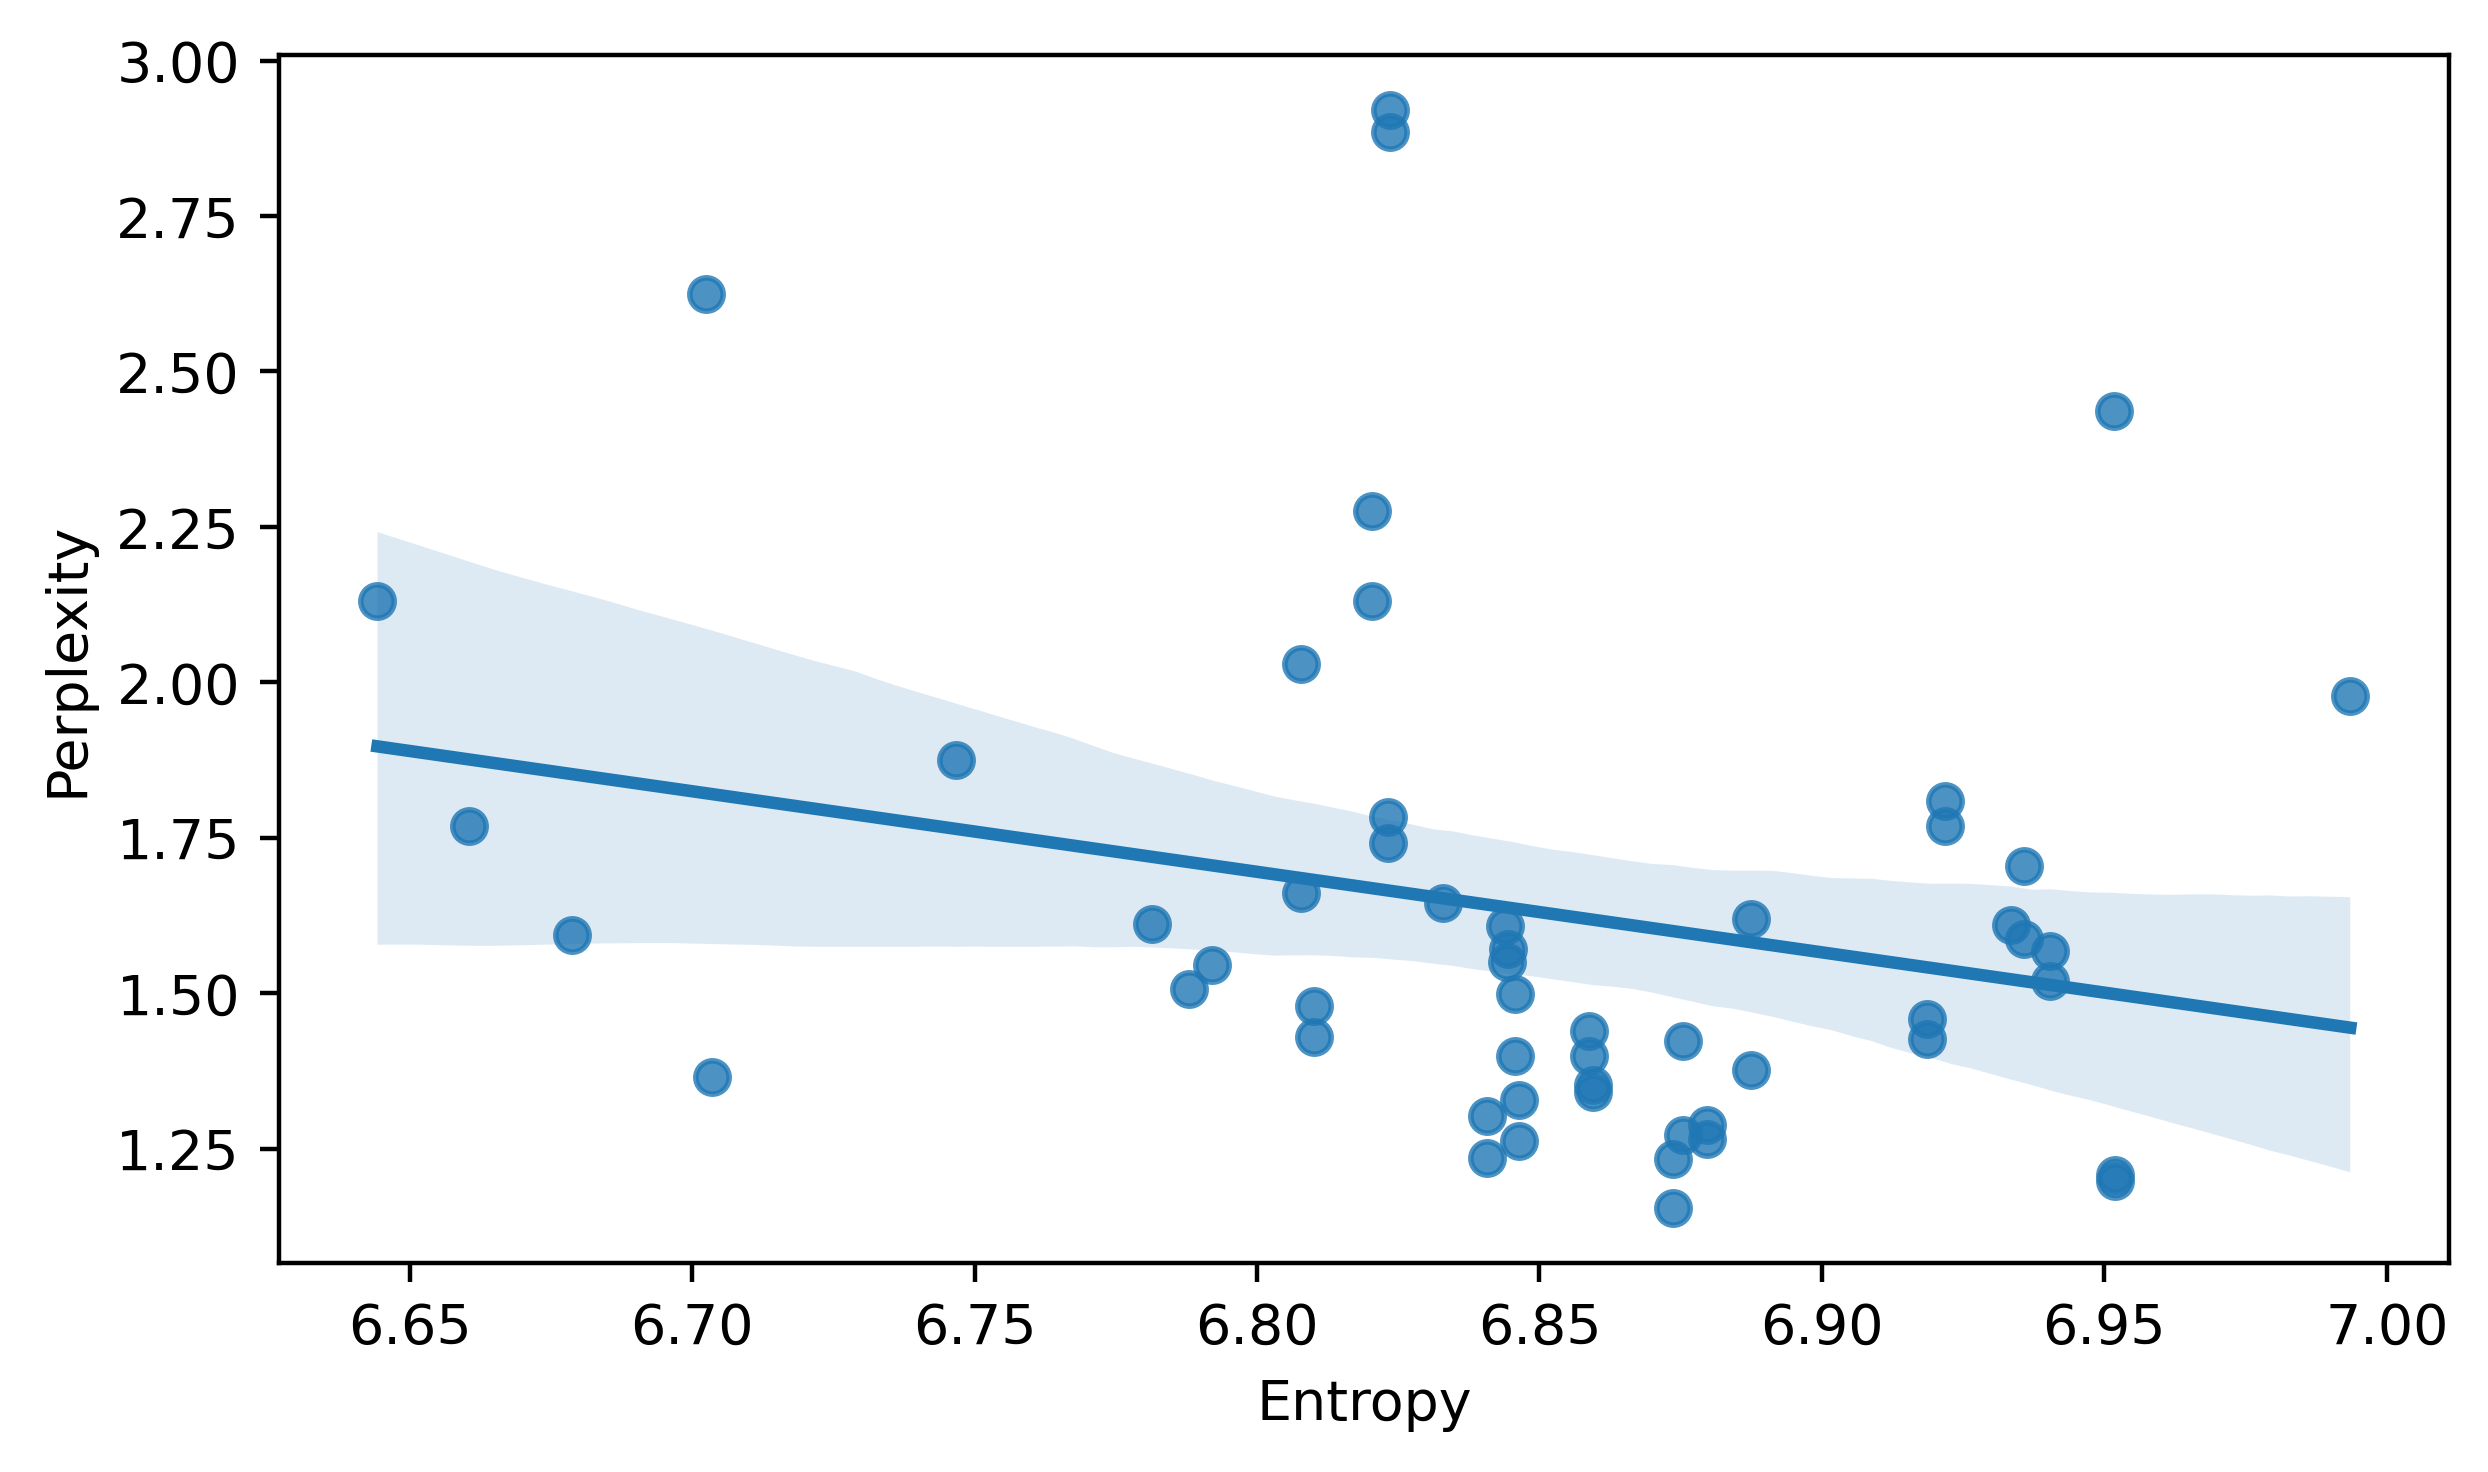

In [17]:
df_ortho_cor = df_ortho[df_ortho["Epoch"] == "1"][["Entropy", "Perplexity"]].corr(method=cor)
print(df_ortho_cor.loc["Entropy", "Perplexity"])
plt.figure(figsize=(x, y), dpi=400)
sns.regplot(data=df_ortho[df_ortho["Epoch"] == "1"], x="Entropy", y="Perplexity")
plt.savefig("cor-ortho."+save_format, format=save_format)

In [18]:
dfo_epoch1 = df_ortho[df_ortho["Epoch"] == "1"]
predf_ortho = {"Entropy Mean": {}, "Entropy SE": {}, "Perplexity Mean": {}, "Perplexity SE": {}}
for id_type in dfo_epoch1["ID"].unique():
    predf_ortho["Entropy Mean"][id_type] = dfo_epoch1[dfo_epoch1["ID"] == id_type]["Entropy"].mean()
    predf_ortho["Entropy SE"][id_type] = dfo_epoch1[dfo_epoch1["ID"] == id_type]["Entropy"].sem()
    predf_ortho["Perplexity Mean"][id_type] = dfo_epoch1[dfo_epoch1["ID"] == id_type]["Perplexity"].mean()
    predf_ortho["Perplexity SE"][id_type] = dfo_epoch1[dfo_epoch1["ID"] == id_type]["Perplexity"].sem()
dfo_mse = pd.DataFrame(predf_ortho)
dfo_mse

,Entropy Mean,Entropy SE,Perplexity Mean,Perplexity SE
none,6.868396,0.023945,1.462052,0.067423
Holland,6.867508,0.018436,1.485068,0.062860
Resourceful,6.874232,0.010895,1.445905,0.077149
Mixed,6.771702,0.023133,2.209990,0.168883
Mono,6.907759,0.018411,1.615566,0.123798
Norman,6.797455,0.024652,1.581173,0.088187
